# ECE 174: Mini-Project 2
## By: Jay Paek

## Set-Up

### Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math

### Define Main Variables and Function

Define $e$ as Euler's constant.

In [2]:
e = np.exp(1)
e

2.718281828459045

$generate\_data\_1$ will create $n$ vectors, $\textbf{x}^{(0)},\textbf{x}^{(1)},...,\textbf{x}^{(n-1)} \in \mathbb{R}^3$ and $n$ values in $\mathbb{R}$ that fall under the following conditions defined by the problem set.
* For any pair ($\textbf{x}^{(i)}, y^{(i)}$) such that $i = 0, 1, ..., n-1$ and $\textbf{x} = \begin{bmatrix} x^{(i)}_1 & x^{(i)}_2 & x^{(i)}_3\end{bmatrix}$, $y^{(i)} =  x^{(i)}_1 x^{(i)}_2 + x^{(i)}_3$
* The values for $\textbf{max}\{x^{(i)}_1 , x^{(i)}_2 , x^{(i)}_3\} \leq \Gamma$ 
* The values for $x^{(i)}_1 , x^{(i)}_2 , x^{(i)}_3$  are randomly generated under a Gaussian distribution

In [3]:
def generate_data_1(n, gamma):
    data = np.empty((0,3))
    out = np.empty((0,1))
    for i in range(n):
        x = np.random.uniform(-gamma, gamma, (3,))
        data = np.vstack((data,x))
        out = np.append(out,[x[0]*x[1]+x[2]])
    return data, out

$d\_tanh$ will find the derivative at some point $x$ for the hyperbolic tangent function.

In [4]:
def d_tanh(x):
    return (4*e**(2*x))/((e**(2*x)+1)**2)

Define the approximator function:
$$f_{\textbf{w}}(\textbf{x}) = w_1\phi(w_2x_1 + w_3x_2 + w_4x_3 + w_5) + w_6\phi(w_7x_1 + w_8x_2 + w_9x_3 + w_{10}) + w_{11}\phi(w_{12}x_1 + w_{13}x_2 + w_{14}x_3 + w_{15}) + w_{16}$$
Where $\phi$ is $tanh$

In [5]:
def f(x, weights):
    return weights[0]*np.tanh(weights[1]*x[0] + weights[2]*x[1] + weights[3]*x[2] + weights[4]) + \
            weights[5]*np.tanh(weights[6]*x[0] + weights[7]*x[1] + weights[8]*x[2] + weights[9]) + \
            weights[10]*np.tanh(weights[11]*x[0] + weights[12]*x[1] + weights[13]*x[2] + weights[14]) + weights[15]

def f_vector(data, weights):
    result = np.empty((0,))
    for x in data:
        result = np.concatenate((result, np.asarray([f(x, weights)])))
    return result

$g\_tanh$ will find the gradient of $f(\text{x})$ with the gradient vector defined as the following:
$$\nabla_{\textbf{w}} = \begin{bmatrix} \frac{\partial}{\partial w_1} & \frac{\partial}{\partial w_2} & ... & \frac{\partial}{\partial w_{16}} \end{bmatrix}$$ 

In [6]:
def g_tanh(x, weights):
    return np.asarray([
        np.tanh(weights[1]*x[0] + weights[2]*x[1] + weights[3]*x[2] + weights[4]),
        weights[0]*x[0] * d_tanh(weights[1]*x[0] + weights[2]*x[1] + weights[3]*x[2] + weights[4]),
        weights[0]*x[1] * d_tanh(weights[1]*x[0] + weights[2]*x[1] + weights[3]*x[2] + weights[4]),
        weights[0]*x[2] * d_tanh(weights[1]*x[0] + weights[2]*x[1] + weights[3]*x[2] + weights[4]),
        weights[0] * d_tanh(weights[1]*x[0] + weights[2]*x[1] + weights[3]*x[2] + weights[4]),
        np.tanh(weights[6]*x[0] + weights[7]*x[1] + weights[8]*x[2] + weights[9]),
        weights[5]*x[0] * d_tanh(weights[6]*x[0] + weights[7]*x[1] + weights[8]*x[2] + weights[9]),
        weights[5]*x[1] * d_tanh(weights[6]*x[0] + weights[7]*x[1] + weights[8]*x[2] + weights[9]),
        weights[5]*x[2] * d_tanh(weights[6]*x[0] + weights[7]*x[1] + weights[8]*x[2] + weights[9]),
        weights[5] * d_tanh(weights[6]*x[0] + weights[7]*x[1] + weights[8]*x[2] + weights[9]),
        np.tanh(weights[11]*x[0] + weights[12]*x[1] + weights[13]*x[2] + weights[14]),
        weights[10]*x[0] * d_tanh(weights[11]*x[0] + weights[12]*x[1] + weights[13]*x[2] + weights[14]),
        weights[10]*x[1] * d_tanh(weights[11]*x[0] + weights[12]*x[1] + weights[13]*x[2] + weights[14]),
        weights[10]*x[2] * d_tanh(weights[11]*x[0] + weights[12]*x[1] + weights[13]*x[2] + weights[14]),
        weights[10] * d_tanh(weights[11]*x[0] + weights[12]*x[1] + weights[13]*x[2] + weights[14]),
        1
    ])

The $gradient\_matrix$ function will compute the gradient matrix:
$$\begin{bmatrix}
(\nabla_{\textbf{w}}f_{\textbf{w}}(\textbf{x}^{(1)}))^T \\ (\nabla_{\textbf{w}}f_{\textbf{w}}(\textbf{x}^{(2)}))^T \\ ... \\ (\nabla_{\textbf{w}}f_{\textbf{w}}(\textbf{x}^{(n)}))^T
\end{bmatrix}$$

In [7]:
def gradient_matrix(data, weights):
    jacobian = np.empty((0, weights.shape[0]))
    for x in data:
        jacobian = np.vstack((jacobian, g_tanh(x, weights)))
    return jacobian

In [8]:
def find_weights(data, expected, lamb=0.00001, first_step=1, variation=1, weights=None, stop=1, max_iter=999):
    if weights is None:
        weights=np.random.normal(0, variation, (16,))
    trust=0.8
    distrust = 2
    diff = np.sum((f_vector(data, weights) - expected)**2)
    err = diff+lamb*np.linalg.norm(weights)
    step = first_step
    steps = [step]
    errs = [err]
    # while np.linalg.norm(2*gradient.T@expected) < threshold:
    while (len(errs) == 0 or err > stop) and len(errs) < max_iter:
        try:
            # this part of the code will convert the program to a least squares problem
            # First find the gradient matrix
            jacobian = gradient_matrix(data, weights)

            #Initialize a column vector with the expected values with the given weights
            predicted = f_vector(data, weights)
            # Find the value we are trying to project
            y = predicted - expected - jacobian @ weights
            y = np.concatenate((y, np.zeros((weights.shape))), axis=0)
            y = np.concatenate((y, -1*math.sqrt(step)*weights), axis=0)

            # Create the range space by appending the trust value to the gradient matrix
            A = np.concatenate((jacobian, math.sqrt(lamb)*np.identity(jacobian.shape[1])), axis=0)
            A = np.concatenate((A, math.sqrt(step)*np.identity(jacobian.shape[1])), axis=0)

            # Solve least squares problem
            new_weights = np.linalg.pinv(A)@y
            # Calculate the error for newly create weights from solving least squares problem
            diff = np.sum((f_vector(data, new_weights) - expected)**2)
            new_err = diff+lamb*np.linalg.norm(new_weights)

            # print(err, end=' ')
            # print(new_err)
            # Check if the new error is less than the previous error, otherwise, increase lamba
            if new_err < err:
                weights = new_weights
                err = new_err
                step = trust*step
            else:
                step = distrust*step

            # add step and error values to the list for plotting
            steps.append(step)
            errs.append(err)
        except KeyboardInterrupt:
            return None, None, None
        except LinAlgError:
            return 
        """
        except (AttributeError, TypeError) as e:
            print("Diverged")
            if fail:
                return errs, steps, None
            weights = np.random.normal(0, variation, (16,))
            err = np.sum((f_vector(data, weights) - expected)**2)+lamb*np.linalg.norm(weights)
            step = first_step
            steps = [step]
            errs = [err]   
        """
        
    # record training loss for last iteration
    return errs, steps, weights

# The Levenberg-Marquardt Algorithm

In [18]:
# set up variables (trust is set to an arbitrary value for now)
data, expected = generate_data_1(500, 1)

In [470]:
errs, steps, weights = find_weights(data, expected, lamb=0.00001, max_iter=1000, stop=0.1, variation=10)

59.80866437304412

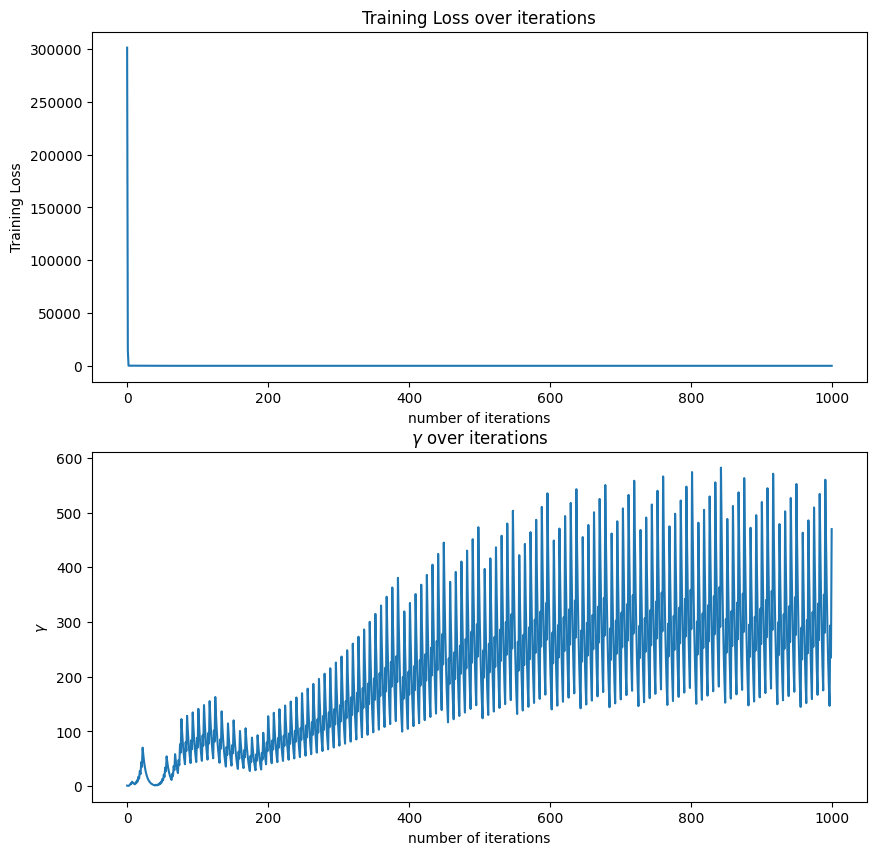

In [472]:
fig, arr = plt.subplots(2,1)
fig.set_size_inches(10, 10)

arr[0].plot(errs)
arr[0].set_title(r'Training Loss over iterations')
arr[0].set_xlabel('number of iterations')
arr[0].set_ylabel('Training Loss')
arr[1].plot(steps)
arr[1].set_title(r'$\gamma$ over iterations')
arr[1].set_xlabel('number of iterations')
arr[1].set_ylabel(r'$\gamma$')

In [82]:
min_weights = np.array([-6.16513227e+00,  3.80465747e-01, -3.05062036e-01,  4.99133757e-04,
       -7.24677442e-01, -6.15219136e+00, -3.80686885e-01, -3.00893215e-01,
       -1.51453437e-03,  7.01337424e-01,  1.31843411e+01, -2.79559841e-03,
       -1.78757268e-01,  7.63469125e-02, -7.44133516e-03,  1.76548829e-05])

In [85]:
np.sqrt(np.sum((f_vector(data, min_weights) - expected)**2)/500)

0.011539877416158736

## Testing on Varied Starting values

The following code will vary the variance in the random weights.

In [62]:
all_losses = []
all_iters = []
all_errs = []
all_vals = [[a*(10**b) for a in range(20)] for b in range(-5,1)]
for i in all_vals:
    loss = []
    iters = []
    error = []
    for j in i:
        total_loss = []
        total_iters = []
        total_errs = []
        for k in range(25):
            errs, steps, weights = find_weights(data, expected, lamb=0.00001, stop=25, max_iter=50, variation=j)
            total_loss.append(errs[-1])
            total_iters.append(len(errs))
            total_errs.append(np.sum((f_vector(data, weights) - expected)**2))
        loss.append(sum(total_loss)/500/len(total_loss))
        iters.append(sum(total_iters)/len(total_iters))
        error.append(sum(total_errs)/500/len(total_errs))
    all_losses.append(loss)
    all_iters.append(iters)
    all_errs.append(error)

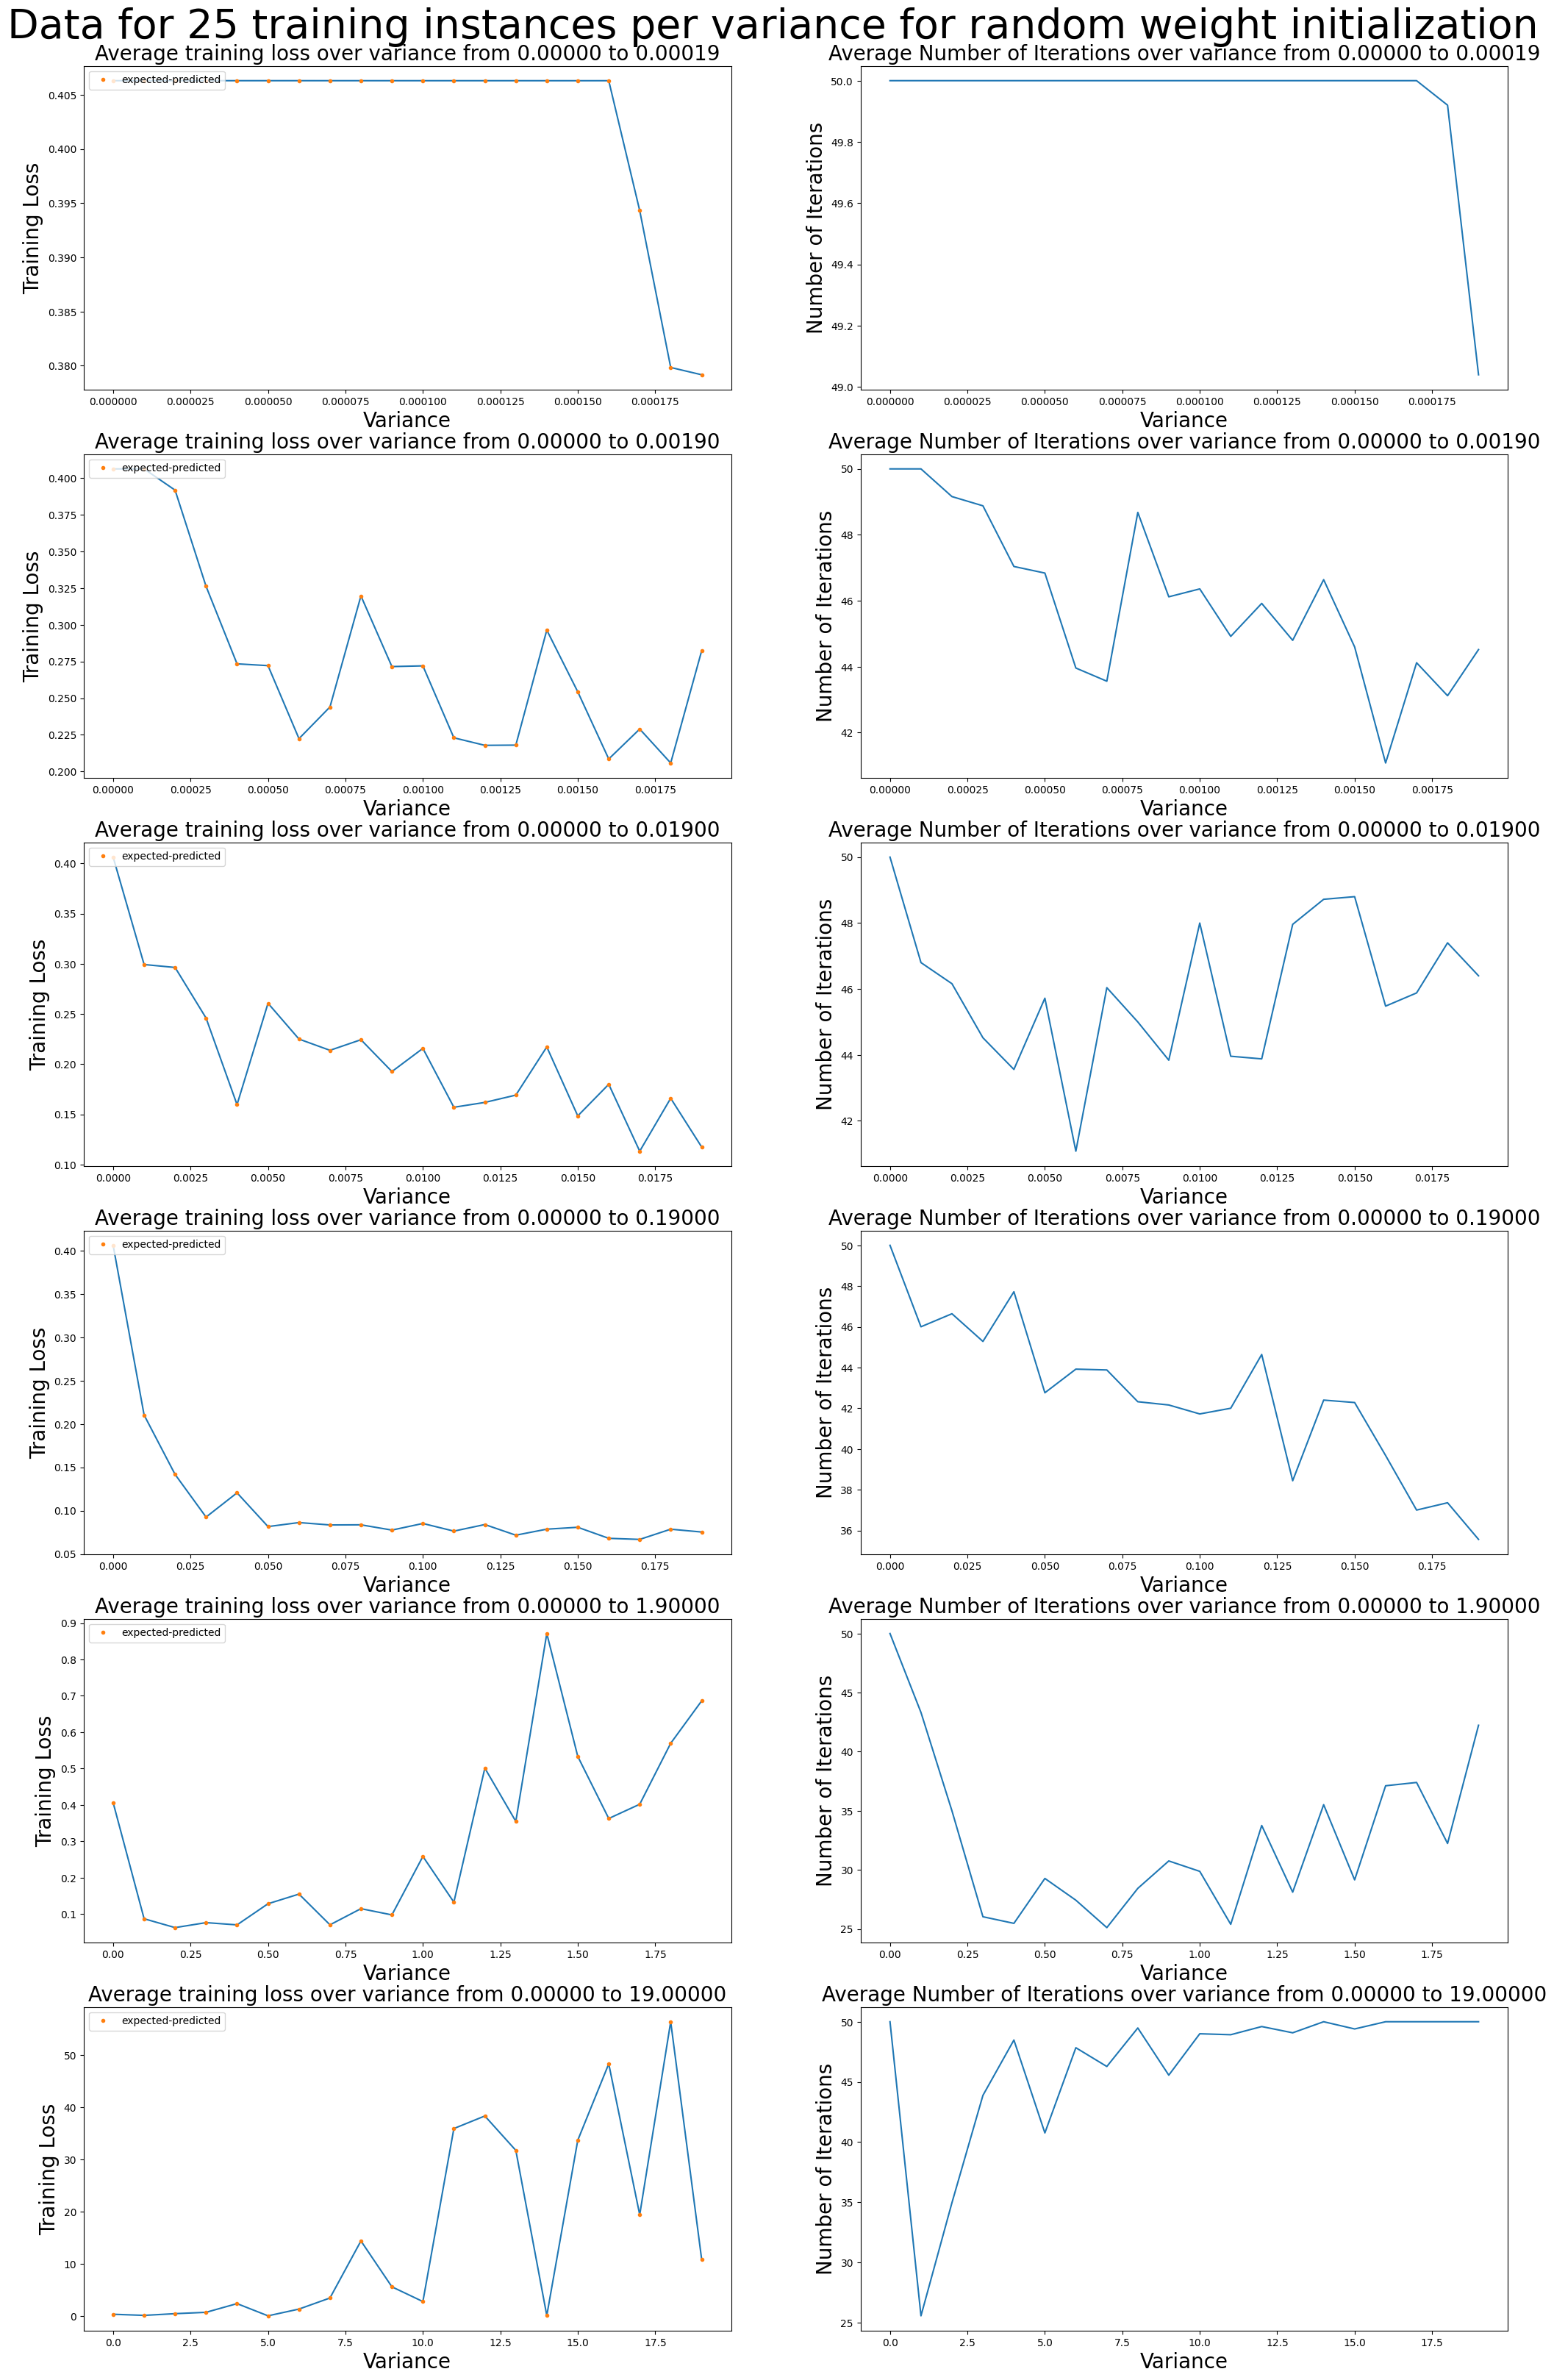

In [127]:
fig, arr = plt.subplots(len(all_vals),2)
fig.set_size_inches(25, 40)
fig.suptitle('Data for 25 training instances per variance for random weight initialization', fontsize=40, y=0.9)
for i in range(len(all_vals)):
    p = arr[i]
    p[0].plot(all_vals[i], all_losses[i])
    p[0].plot(all_vals[i], all_errs[i], '.', label='expected-predicted')
    p[1].plot(all_vals[i], all_iters[i])
    p[0].set_title(r'Average training loss over variance from {:.5f} to {:.5f}'.format(all_vals[i][0], all_vals[i][-1]), fontsize=20)
    p[0].set_xlabel(r'Variance', fontsize=20)
    p[0].set_ylabel('Training Loss', fontsize=20)
    p[0].legend(loc="upper left")
    p[1].set_title(r'Average Number of Iterations over variance from {:.5f} to {:.5f}'.format(all_vals[i][0], all_vals[i][-1]), fontsize=20)
    p[1].set_xlabel(r'Variance', fontsize=20)
    p[1].set_ylabel('Number of Iterations', fontsize=20)

In [284]:
lambs = [0.00001] + [0.00005*i for i in range(1,1000)]
all_losses = []
all_iters = []
all_errs = []
for i in range(len(lambs)):
    errs, steps, weights = find_weights(data, expected, lamb=lambs[i], stop=25, max_iter=100)
    all_losses.append(errs[-1])
    all_iters.append(len(errs))
    all_errs.append(np.sum((f_vector(data, weights) - expected)**2))

Text(0, 0.5, 'Number of Iterations')

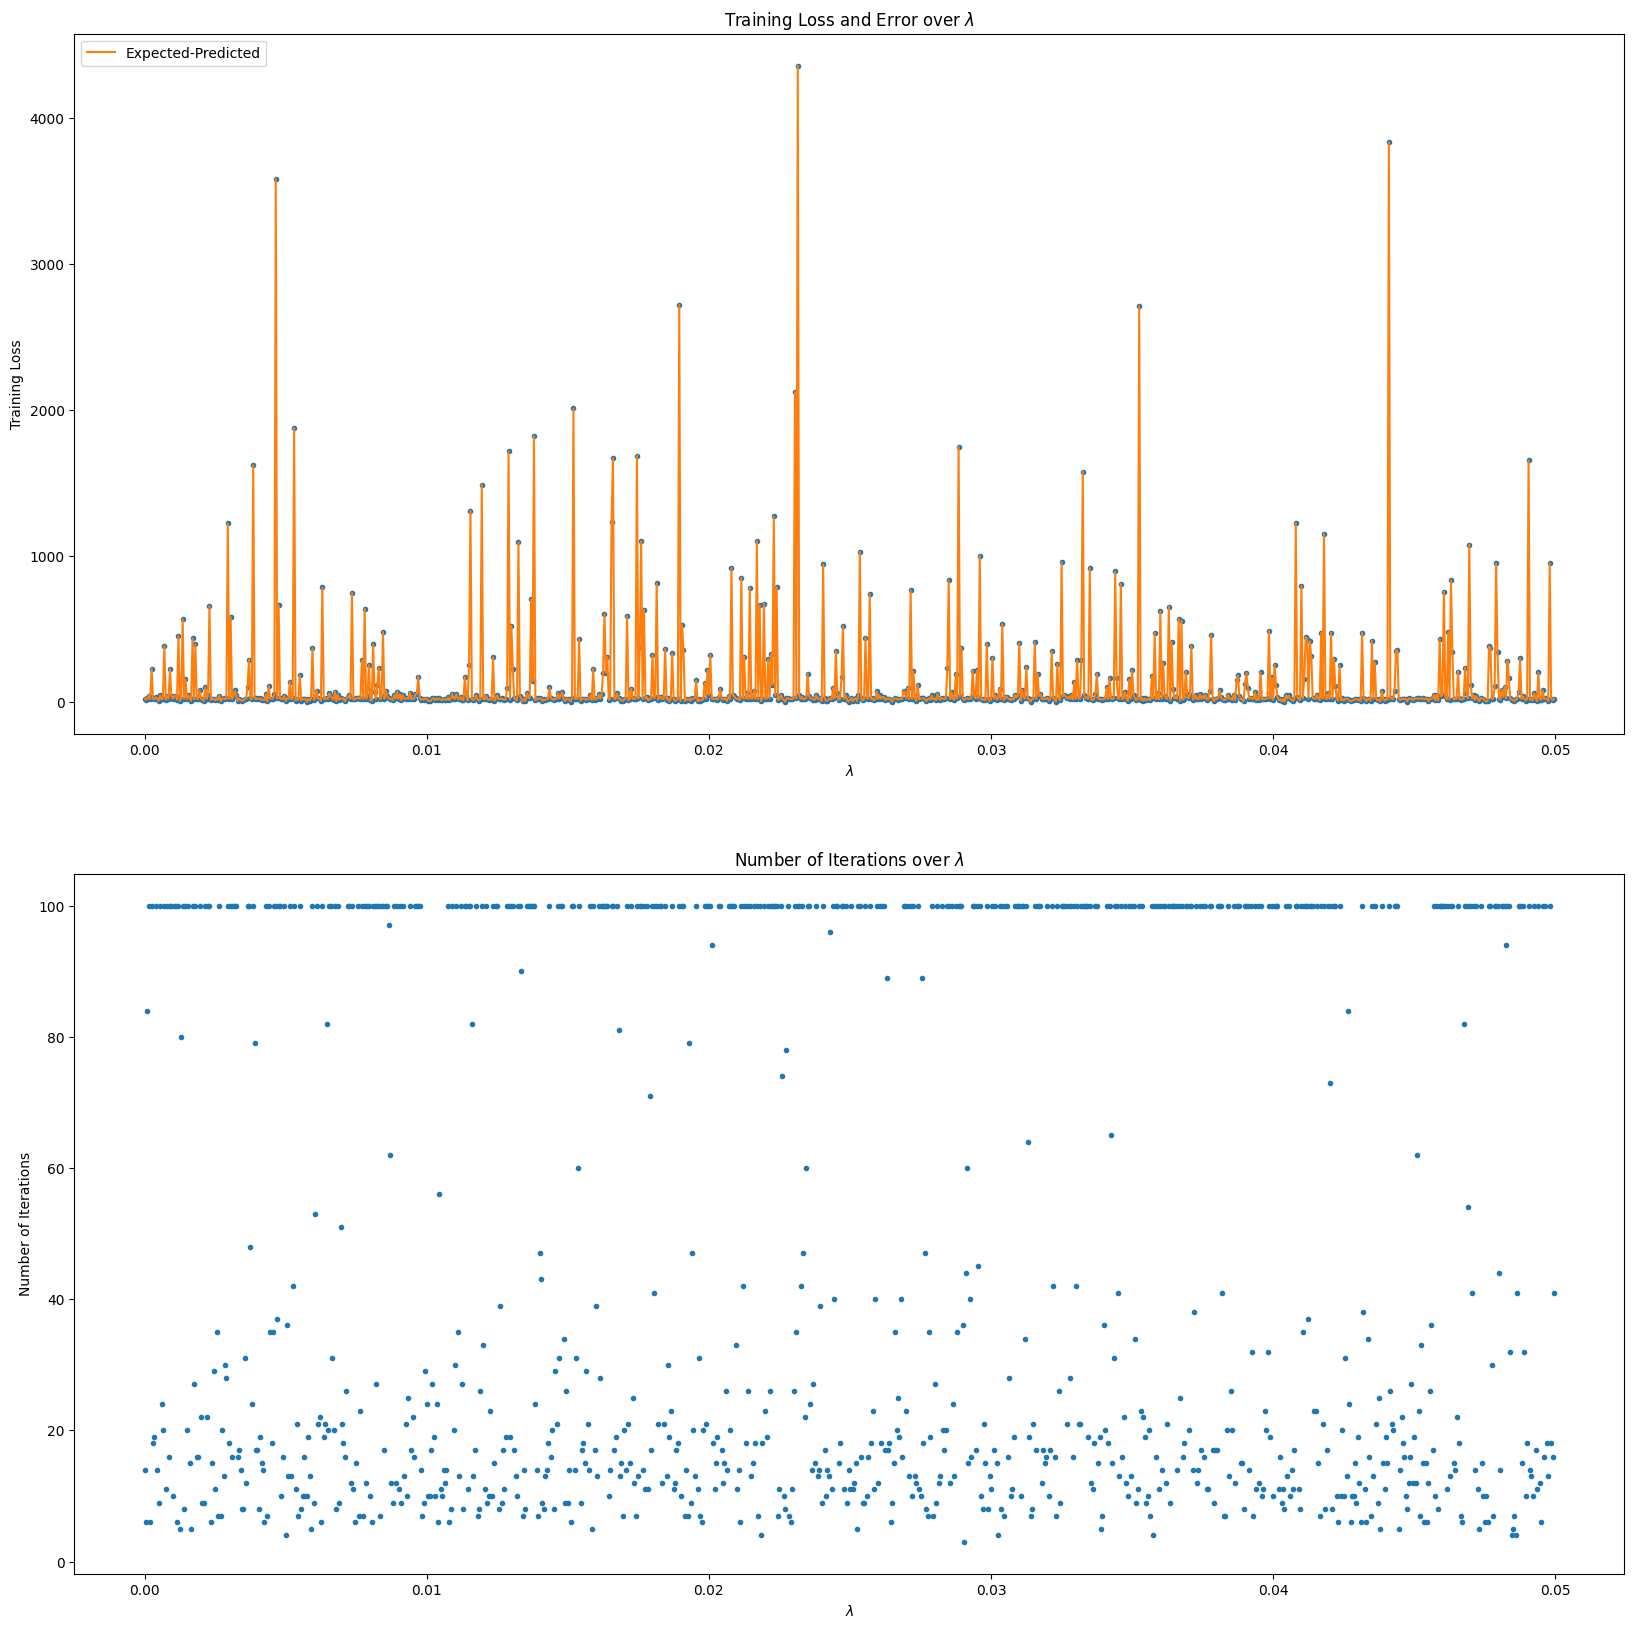

In [286]:
fig, arr = plt.subplots(2,1)
fig.set_size_inches(20, 20)
arr[0].plot(lambs, all_losses, '.')
arr[0].plot(lambs, all_errs, label='Expected-Predicted')
arr[0].set_title(r'Training Loss and Error over $\lambda$')
arr[0].set_xlabel(r'$\lambda$')
arr[0].set_ylabel('Training Loss')
arr[0].legend(loc="upper left")
arr[1].plot(lambs, all_iters, '.')
arr[1].set_title(r'Number of Iterations over $\lambda$')
arr[1].set_xlabel(r'$\lambda$')
arr[1].set_ylabel('Number of Iterations')

In [19]:
lambs = [[i*(10**j) for i in range(1,10)] for j in range(-7, 1) ]
all_losses = []
all_iters = []
all_errs = []
for i in lambs:
    loss = []
    iters = []
    error = []
    for j in i:
        total_loss = []
        total_iters = []
        total_errs = []
        for k in range(25):
            errs, steps, weights = find_weights(data, expected, lamb=j, stop=25, max_iter=50)
            total_loss.append(errs[-1])
            total_iters.append(len(errs))
            total_errs.append(np.sum((f_vector(data, weights) - expected)**2))
        loss.append(sum(total_loss)/500/len(total_loss))
        iters.append(sum(total_iters)/len(total_iters))
        error.append(sum(total_errs)/500/len(total_errs))
    all_losses.append(loss)
    all_iters.append(iters)
    all_errs.append(error)

ValueError: x and y must have same first dimension, but have shapes (1,) and (9,)

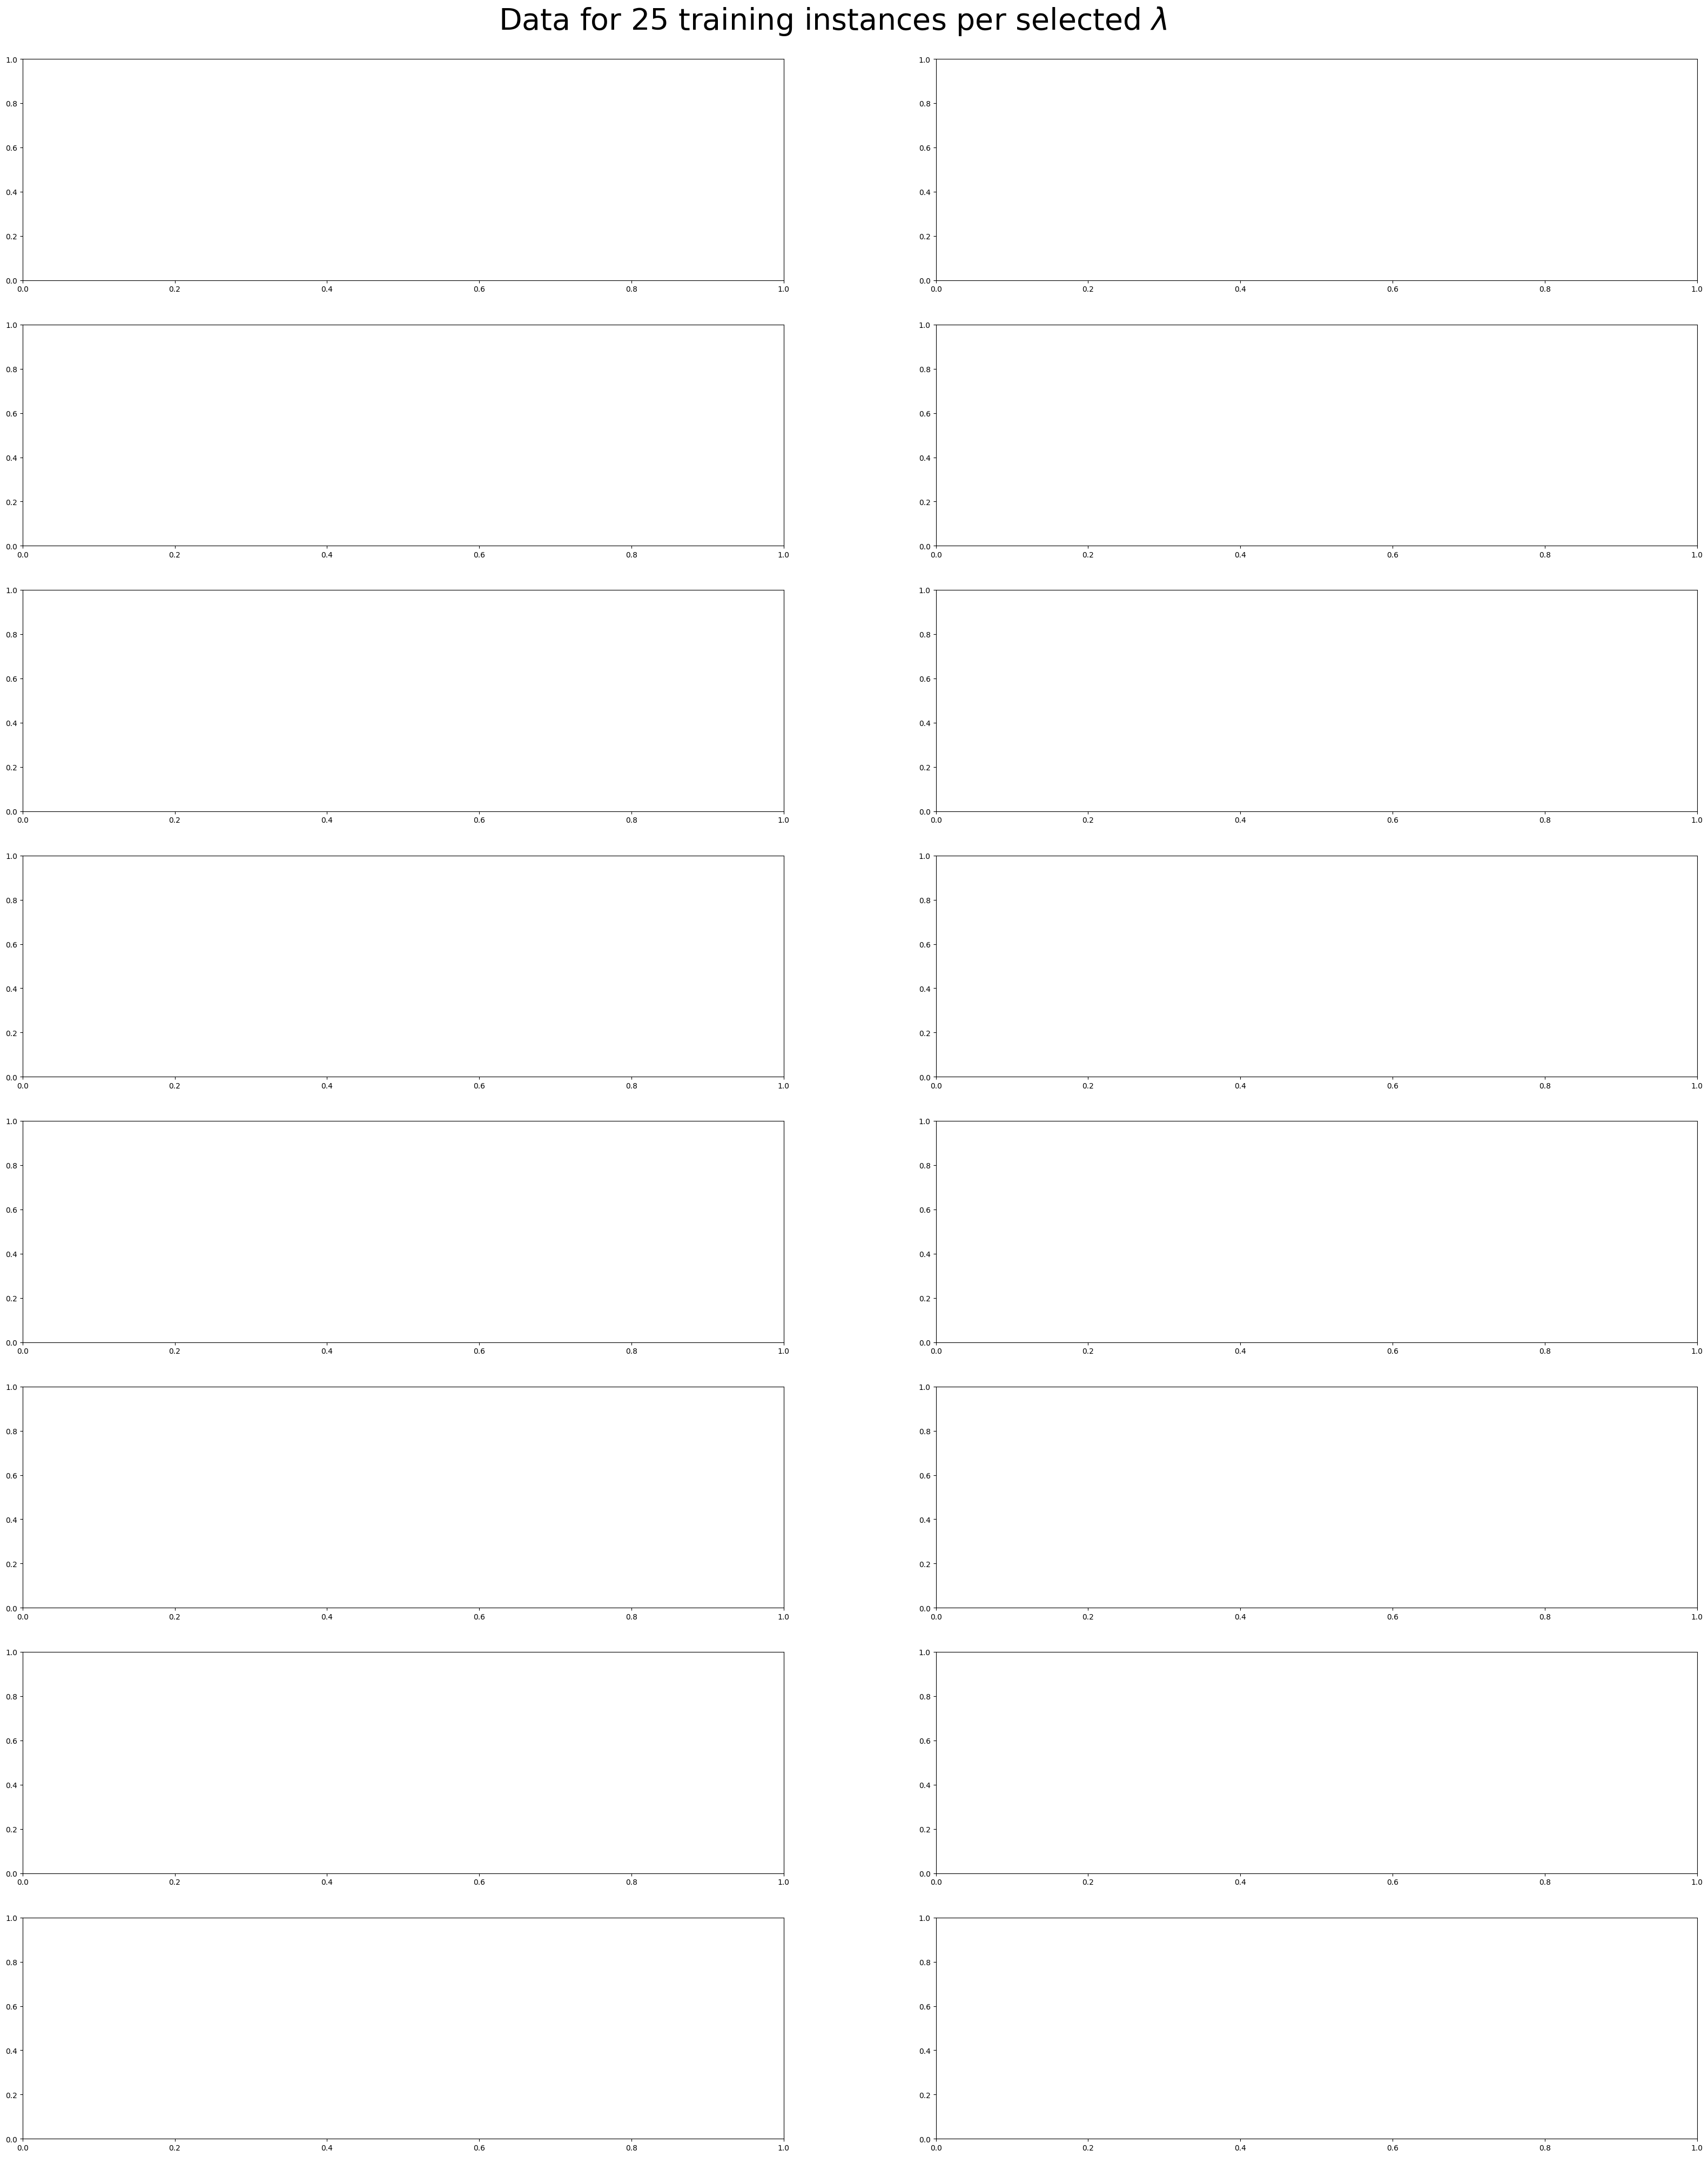

In [32]:
fig, arr = plt.subplots(len(lambs),2)
fig.set_size_inches(40, 50)
fig.suptitle(r'Data for 25 training instances per selected $\lambda$', fontsize=40, y=0.9)
for i in range(len(lambs)):
    p = arr[i]
    p[0].plot(lambs[i], all_losses[i])
    p[0].plot(lambs[i], all_errs[i], '.', label='expected-predicted')
    p[1].plot(lambs[i], all_iters[i])
    p[0].set_title(r'Average training loss over $\lambda$ from {:.5f} to {:.5f}'.format(lambs[i][0], lambs[i][-1]), fontsize=20)
    p[0].set_xlabel(r'$\lambda$', fontsize=20)
    p[0].set_ylabel('Training Loss', fontsize=20)
    p[0].legend(loc="upper left")
    p[1].set_title(r'Average Number of Iterations over $\lambda$ from {:.5f} to {:.5f}'.format(lambs[i][0], lambs[i][-1]), fontsize=20)
    p[1].set_xlabel(r'$\lambda$', fontsize=20)
    p[1].set_ylabel('Number of Iterations', fontsize=20)

## Testing the Model on different $\Gamma$ and $\lambda$

The following code will attempt the Levenburg Marquadt Algorithm on varying values of $\Gamma$ which was the limiting value for the magnitudes of input values.

In [40]:
gammas = [1] + [i*(10**-2) for i in range(1, 1000)]
lambs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
all_errs = []
data, expected = generate_data_1(500, 1)
w = np.random.normal(0,1,(16,))
for h in lambs:
    _, _, weights = find_weights(data, expected, lamb=h, stop=25, max_iter=25, weights=w )
    avg_errs = []
    print(h)
    for i in range(len(gammas)):
        errs = []
        for j in range(25):
            data_new, data_expected = generate_data_1(100, gammas[i])
            err = np.sum((f_vector(data_new, weights) - data_expected)**2)
            errs.append(err)
        avg_errs.append(sum(errs)/len(errs)/len(gammas))
    all_errs.append(avg_errs)

1e-05
0.0001
0.001
0.01
0.1
1
10
100


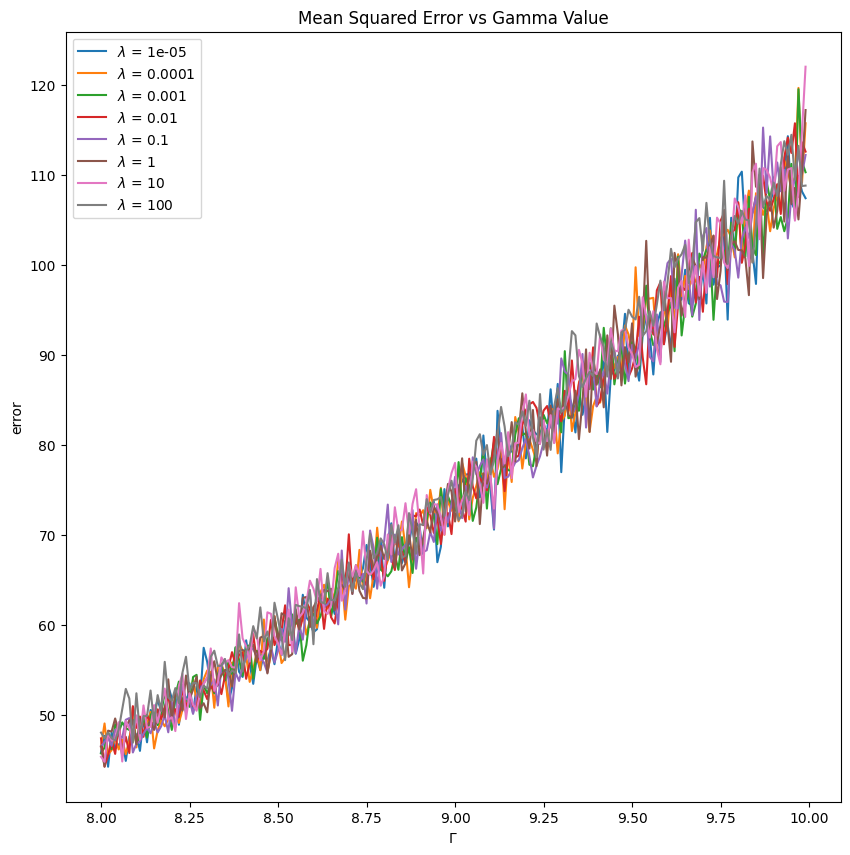

In [67]:
fig, arr = plt.subplots(1)
fig.set_size_inches(10, 10)
for i in range(len(all_errs)):
    arr.plot(gammas[800:1000], all_errs[i][800:1000], label=r'$\lambda$ = {}'.format(str(lambs[i])))
arr.set_title("Mean Squared Error vs Gamma Value")
arr.set_xlabel(r'$\Gamma$')
arr.set_ylabel('error')
plt.legend(loc="upper left")
plt.show()

The following code will attempt the Levenburg Marquadt Algorithm on varying values of $\lambda$  which was the limiting value for the magnitudes of input values.

# New Non-Linear Function: $[x]_1 - [x]_2[x]_3$

In [9]:
def generate_data_2(n, gamma):
    data = np.empty((0,3))
    out = np.empty((0,1))
    for i in range(n):
        x = np.random.uniform(-gamma, gamma, (3,))
        data = np.vstack((data,x))
        out = np.append(out,[x[0]-x[1]*x[2]])
    return data, out

In [10]:
# set up variables
data_2, expected_2 = generate_data_2(500, 1)

In [11]:
errs, steps, weights = find_weights(data_2, expected_2, lamb=0.00001, max_iter=1000, stop=0.1)

0.09993276091570084

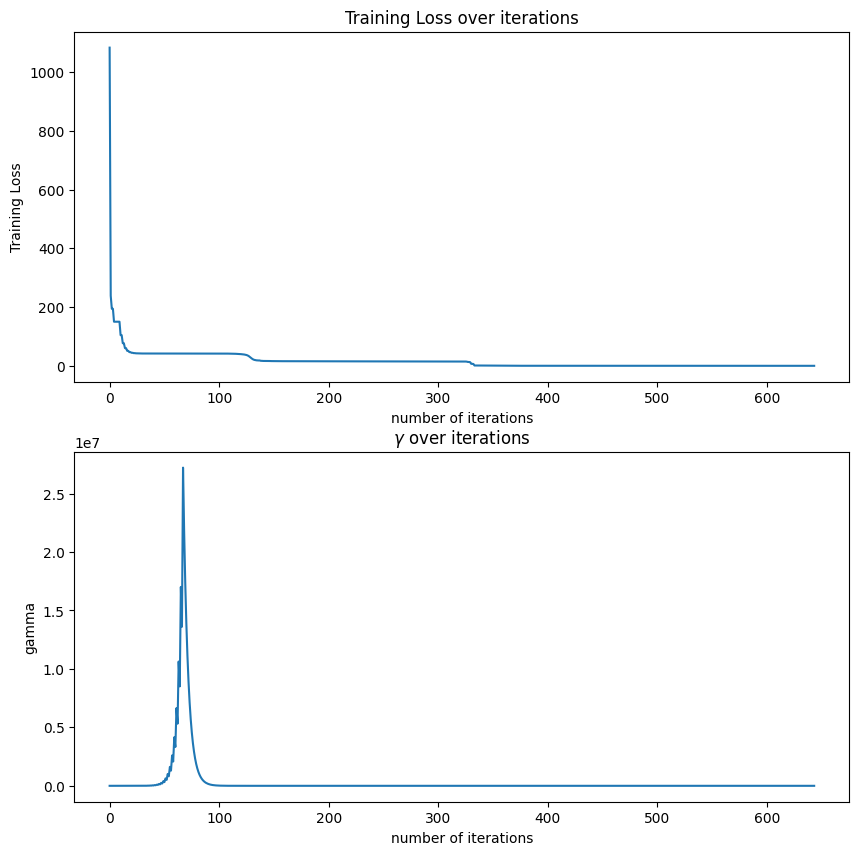

In [12]:
fig, arr = plt.subplots(2,1)
fig.set_size_inches(10, 10)

arr[0].plot(errs)
arr[0].set_title(r'Training Loss over iterations')
arr[0].set_xlabel('number of iterations')
arr[0].set_ylabel('Training Loss')
arr[1].plot(steps)
arr[1].set_title(r'$\gamma$ over iterations')
arr[1].set_xlabel('number of iterations')
arr[1].set_ylabel('gamma')
errs[-1]

## Testing varied initializations on new non-linear function

In [14]:
all_losses = []
all_iters = []
all_errs = []
all_vals = [[a*(10**b) for a in range(20)] for b in range(-5,1)]
for i in all_vals:
    loss = []
    iters = []
    error = []
    for j in i:
        total_loss = []
        total_iters = []
        total_errs = []
        for k in range(25):
            errs, steps, weights = find_weights(data_2, expected_2, lamb=0.00001, stop=25, max_iter=50, variation=j)
            total_loss.append(errs[-1])
            total_iters.append(len(errs))
            total_errs.append(np.sum((f_vector(data_2, weights) - expected_2)**2))
        loss.append(sum(total_loss)/500/len(total_loss))
        iters.append(sum(total_iters)/len(total_iters))
        error.append(sum(total_errs)/500/len(total_errs))
    all_losses.append(loss)
    all_iters.append(iters)
    all_errs.append(error)

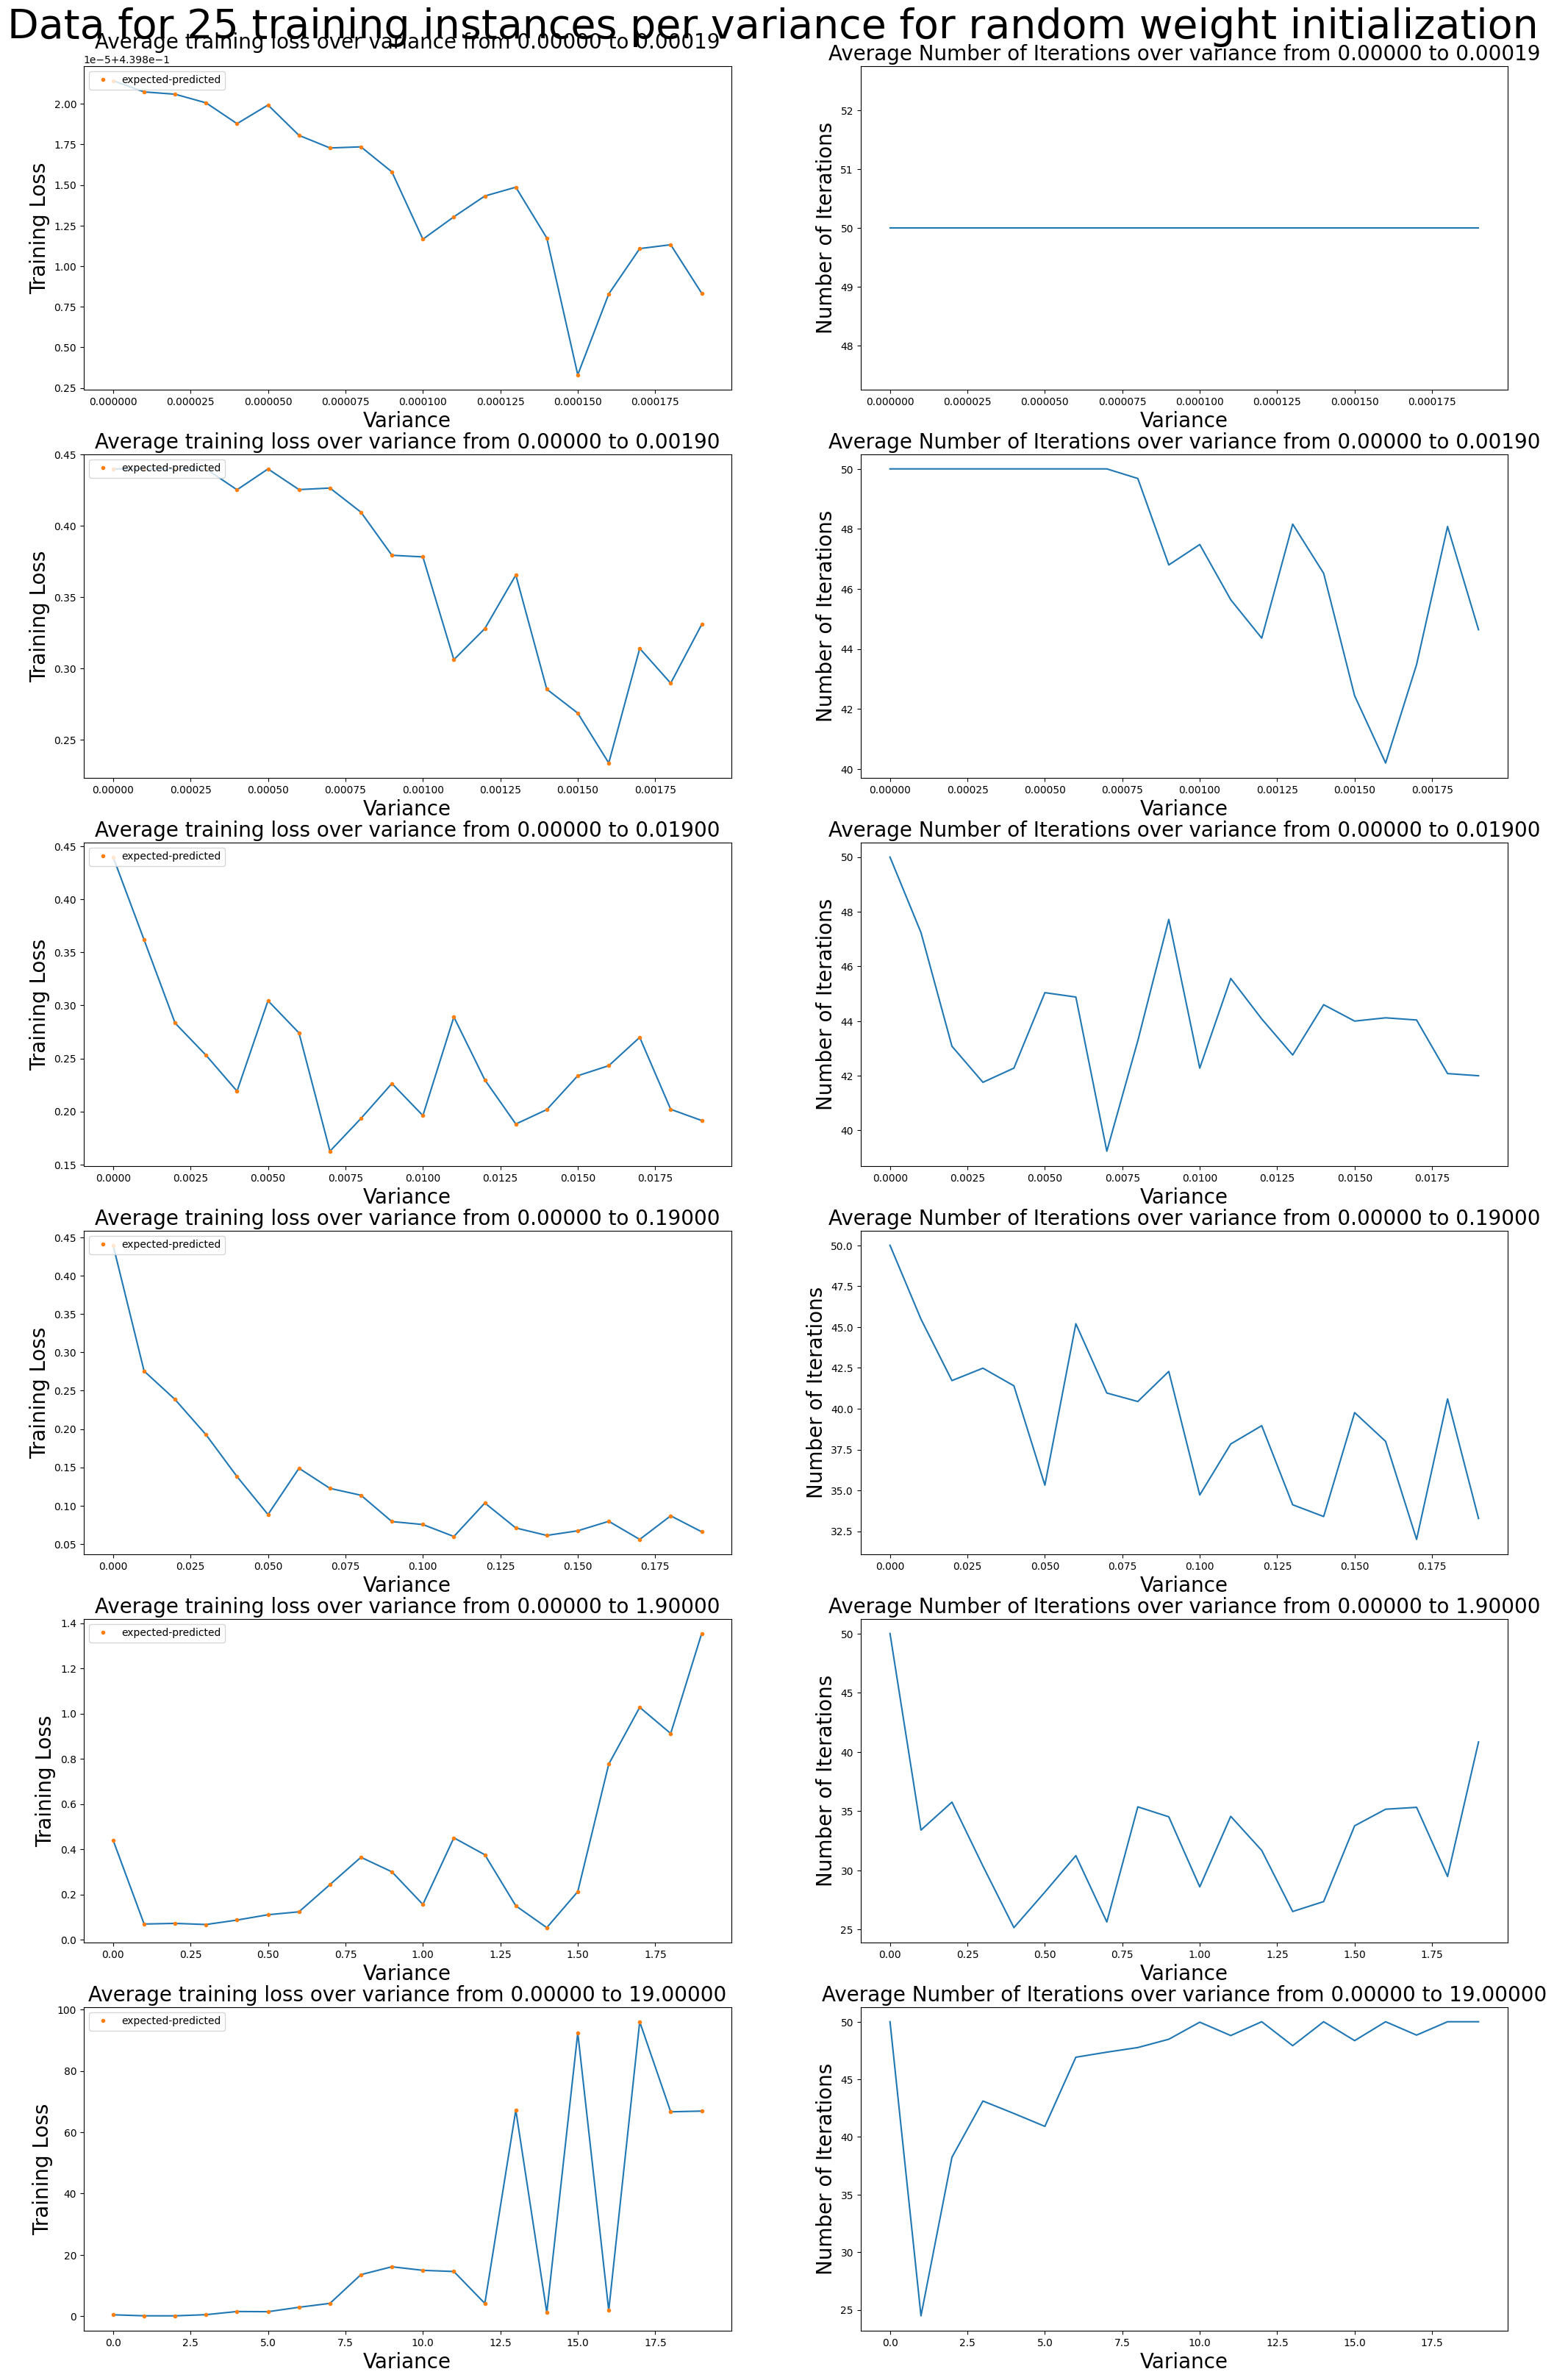

In [15]:
fig, arr = plt.subplots(len(all_vals),2)
fig.set_size_inches(25, 40)
fig.suptitle('Data for 25 training instances per variance for random weight initialization', fontsize=40, y=0.9)
for i in range(len(all_vals)):
    p = arr[i]
    p[0].plot(all_vals[i], all_losses[i])
    p[0].plot(all_vals[i], all_errs[i], '.', label='expected-predicted')
    p[1].plot(all_vals[i], all_iters[i])
    p[0].set_title(r'Average training loss over variance from {:.5f} to {:.5f}'.format(all_vals[i][0], all_vals[i][-1]), fontsize=20)
    p[0].set_xlabel(r'Variance', fontsize=20)
    p[0].set_ylabel('Training Loss', fontsize=20)
    p[0].legend(loc="upper left")
    p[1].set_title(r'Average Number of Iterations over variance from {:.5f} to {:.5f}'.format(all_vals[i][0], all_vals[i][-1]), fontsize=20)
    p[1].set_xlabel(r'Variance', fontsize=20)
    p[1].set_ylabel('Number of Iterations', fontsize=20)

In [33]:
lambs = [[i*(10**j) for i in range(1,10)] for j in range(-7, 1) ]
all_losses = []
all_iters = []
all_errs = []
for i in lambs:
    loss = []
    iters = []
    error = []
    for j in i:
        total_loss = []
        total_iters = []
        total_errs = []
        for k in range(25):
            errs, steps, weights = find_weights(data_2, expected_2, lamb=j, stop=25, max_iter=50)
            total_loss.append(errs[-1])
            total_iters.append(len(errs))
            total_errs.append(np.sum((f_vector(data_2, weights) - expected_2)**2))
        loss.append(sum(total_loss)/500/len(total_loss))
        iters.append(sum(total_iters)/len(total_iters))
        error.append(sum(total_errs)/500/len(total_errs))
    all_losses.append(loss)
    all_iters.append(iters)
    all_errs.append(error)

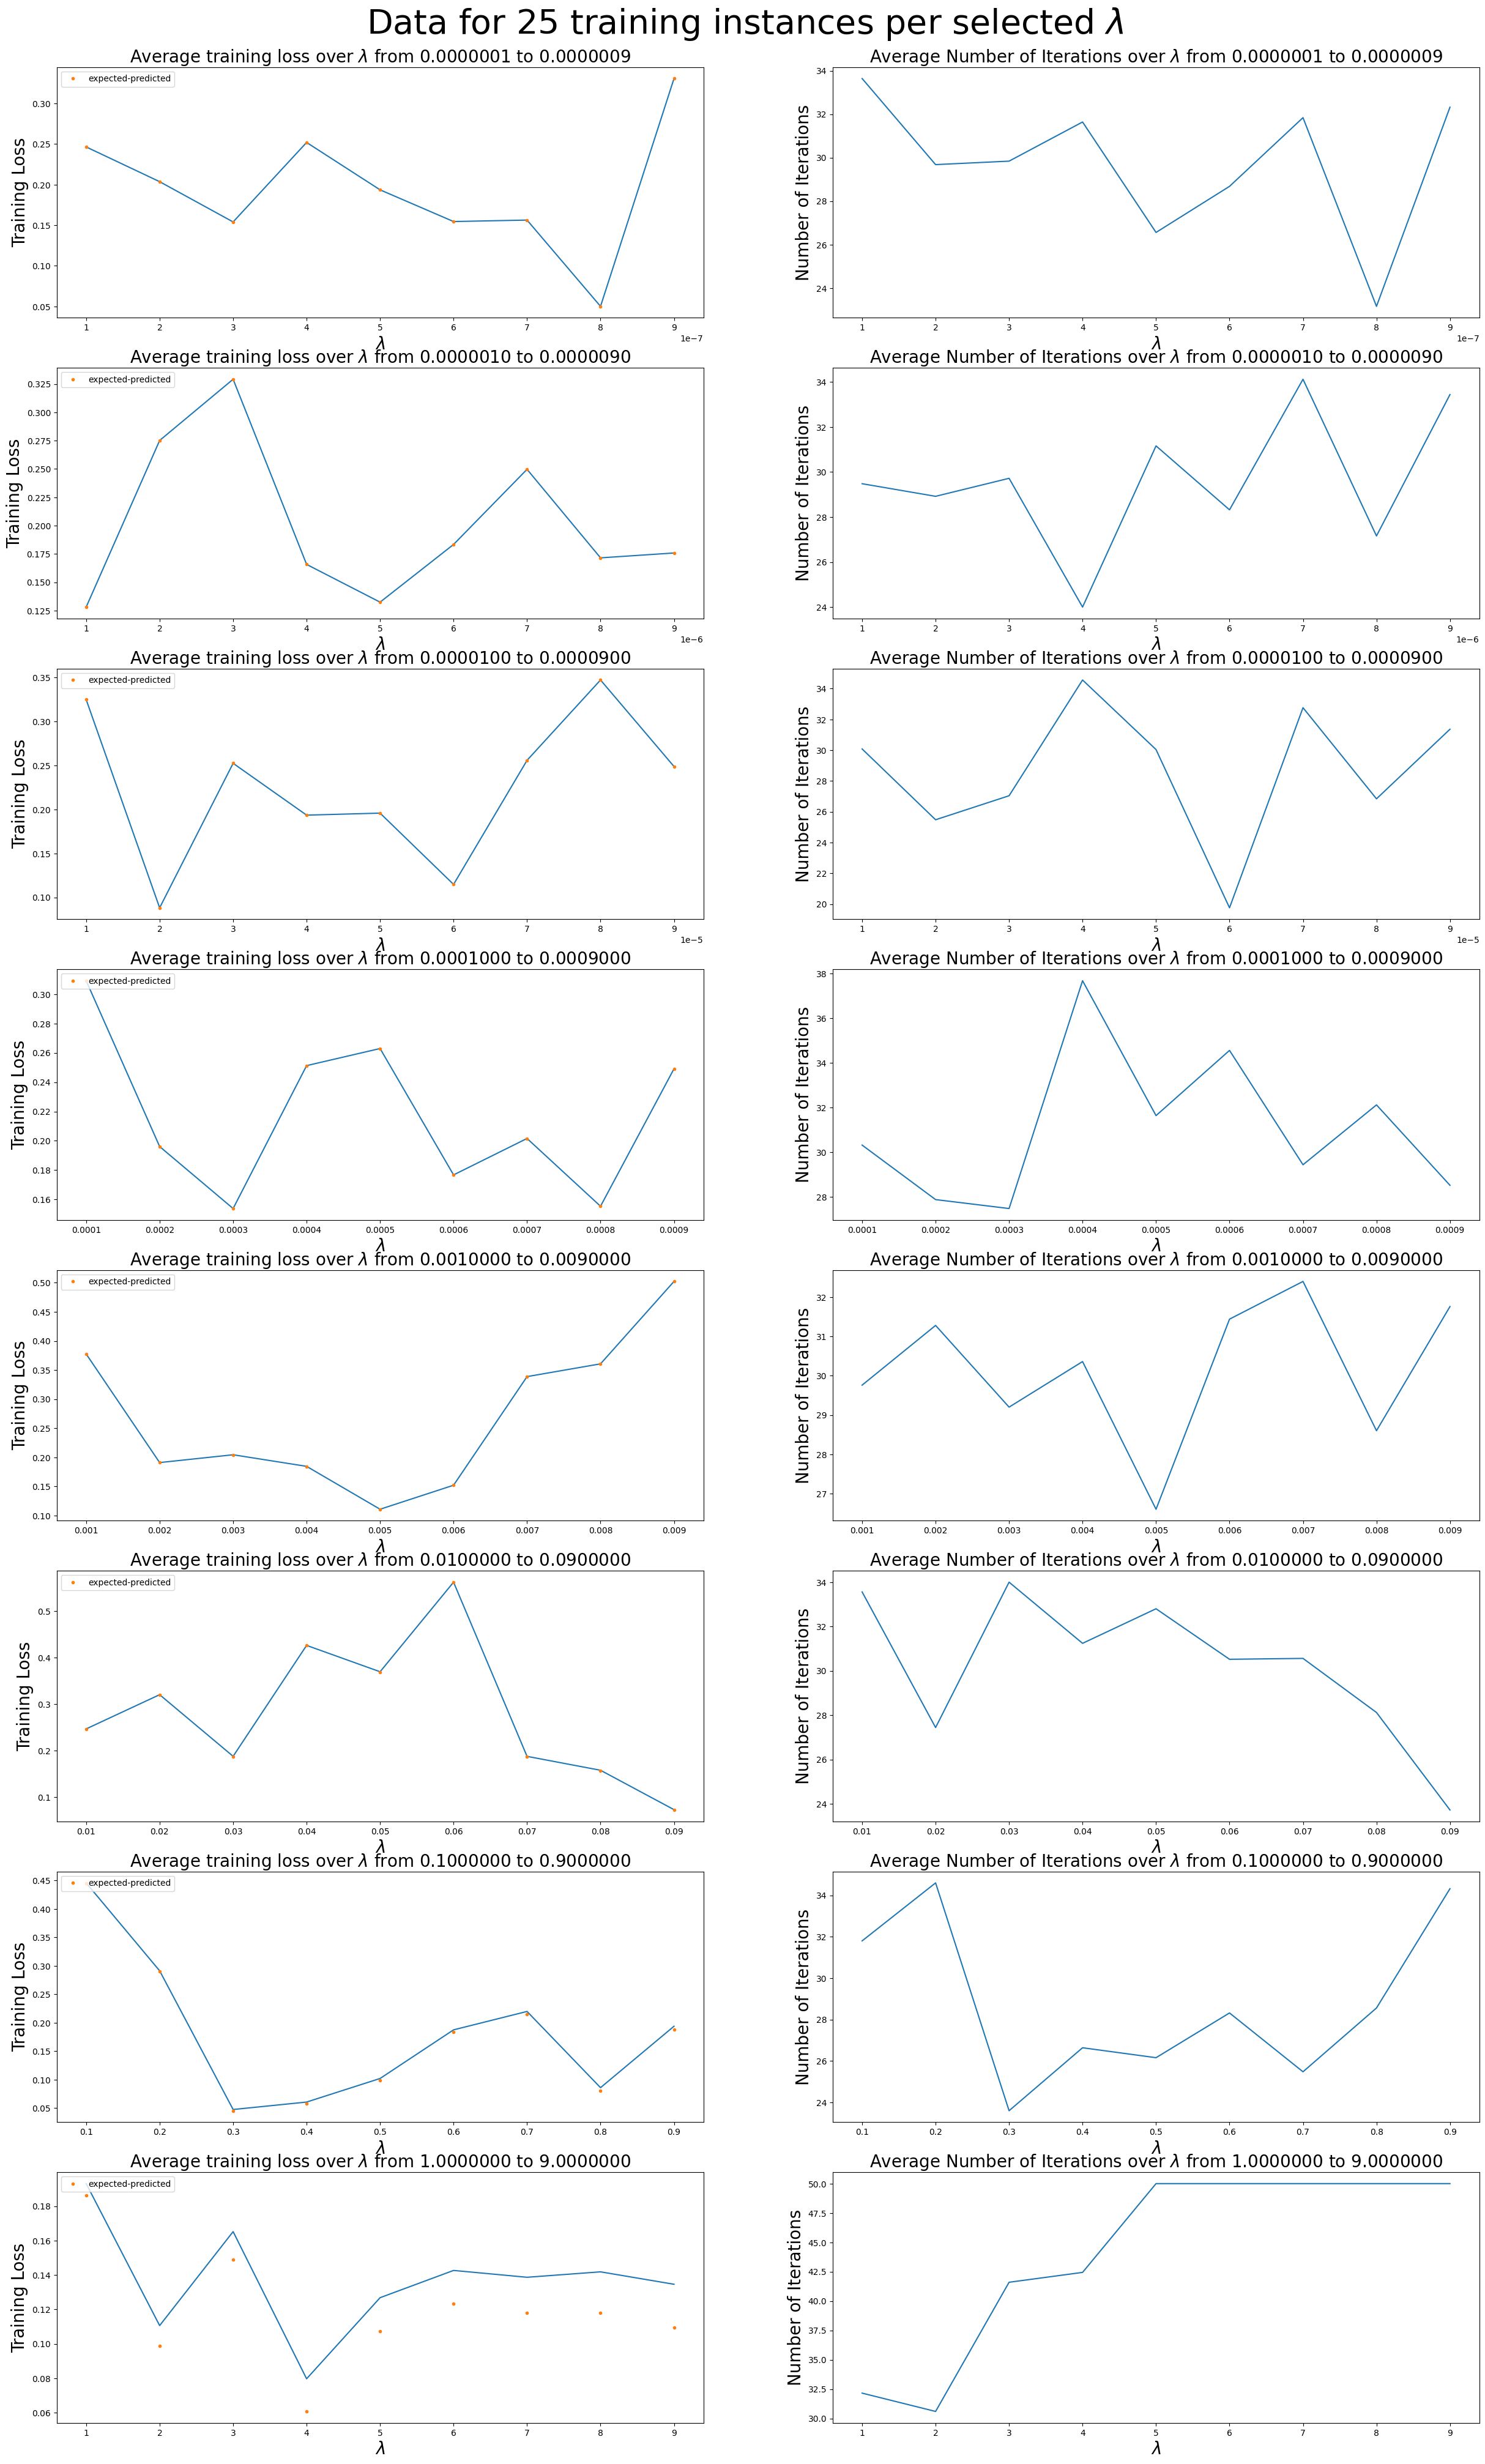

In [36]:
fig, arr = plt.subplots(len(lambs),2)
fig.set_size_inches(30, 50)
fig.suptitle(r'Data for 25 training instances per selected $\lambda$', fontsize=40, y=0.9)
for i in range(len(lambs)):
    p = arr[i]
    p[0].plot(lambs[i], all_losses[i])
    p[0].plot(lambs[i], all_errs[i], '.', label='expected-predicted')
    p[1].plot(lambs[i], all_iters[i])
    p[0].set_title(r'Average training loss over $\lambda$ from {:.7f} to {:.7f}'.format(lambs[i][0], lambs[i][-1]), fontsize=20)
    p[0].set_xlabel(r'$\lambda$', fontsize=20)
    p[0].set_ylabel('Training Loss', fontsize=20)
    p[0].legend(loc="upper left")
    p[1].set_title(r'Average Number of Iterations over $\lambda$ from {:.7f} to {:.7f}'.format(lambs[i][0], lambs[i][-1]), fontsize=20)
    p[1].set_xlabel(r'$\lambda$', fontsize=20)
    p[1].set_ylabel('Number of Iterations', fontsize=20)

## Testing varied $\lambda$ and $\Gamma$  on new non-linear function

In [129]:
gammas = [1] + [i*(10**-2) for i in range(1, 1000)]
lambs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
all_errs = []
data, expected = generate_data_2(500, 1)
w = np.random.normal(0,1,(16,))
for h in lambs:
    _, _, weights = find_weights(data, expected, lamb=h, stop=25, max_iter=25, weights=w )
    avg_errs = []
    print(h)
    for i in range(len(gammas)):
        errs = []
        for j in range(25):
            data_new, data_expected = generate_data_2(100, gammas[i])
            err = np.sum((f_vector(data_new, weights) - data_expected)**2)
            errs.append(err)
        avg_errs.append(sum(errs)/len(errs)/len(gammas))
    all_errs.append(avg_errs)

1e-05
0.0001
0.001
0.01
0.1
1
10
100


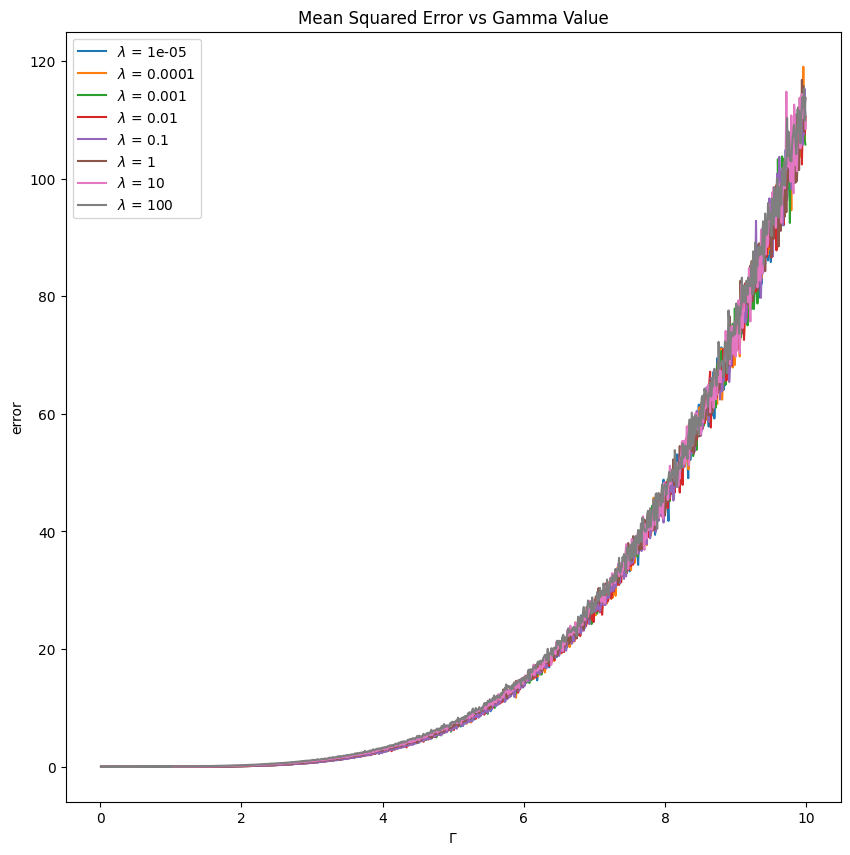

In [131]:
fig, arr = plt.subplots(1)
fig.set_size_inches(10, 10)
for i in range(len(all_errs)):
    arr.plot(gammas[0:1000], all_errs[i][0:1000], label=r'$\lambda$ = {}'.format(str(lambs[i])))
arr.set_title("Mean Squared Error vs Gamma Value")
arr.set_xlabel(r'$\Gamma$')
arr.set_ylabel('error')
plt.legend(loc="upper left")
plt.show()

# Effects of Training Model on Noisy Data

In [136]:
data, expected = generate_data_1(500, 1)
n = np.random.normal(0,1,(500,))
n = n/np.linalg.norm(n)
norms = [i for i in range(1, 100, 2)]
reps = 25

In [149]:
errs, steps, weights = find_weights(data, expected + n * 1, lamb=0.00001, max_iter=1000, stop=0.1)

16.70529665537122

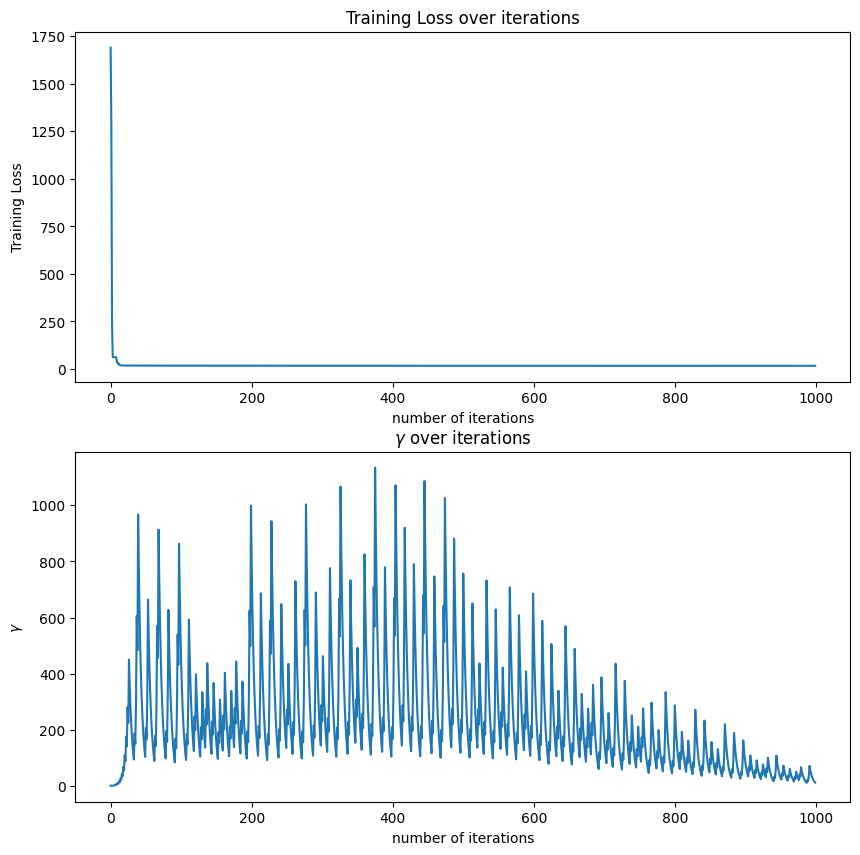

In [150]:
fig, arr = plt.subplots(2,1)
fig.set_size_inches(10, 10)

arr[0].plot(errs)
arr[0].set_title(r'Training Loss over iterations')
arr[0].set_xlabel('number of iterations')
arr[0].set_ylabel('Training Loss')
arr[1].plot(steps)
arr[1].set_title(r'$\gamma$ over iterations')
arr[1].set_xlabel('number of iterations')
arr[1].set_ylabel(r'$\gamma$')
errs[-1]

In [22]:
avg_errs = []
avg_iter = []
all_loss = []
for norm in norms:
    total_errs = []
    total_iters = []
    losses = []
    for i in range(reps):
        errs, steps, weights = find_weights(data, expected + n*norm, lamb=0.0001, stop=25, max_iter=25)
        losses.append(errs)
        total_errs.append(np.sum((f_vector(data, weights)- expected)**2)/500)
        total_iter.append(len(errs))
    avg_errs.append(sum(total_errs)/len(data)/reps)
    avg_iter.append(sum(total_iter)/len(data)/reps)
    all_loss.append(losses)

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61
63
65
67
69
71
73
75
77
79
81
83
85
87
89
91
93
95
97
99


Text(0, 0.5, 'Mean Squared Error')

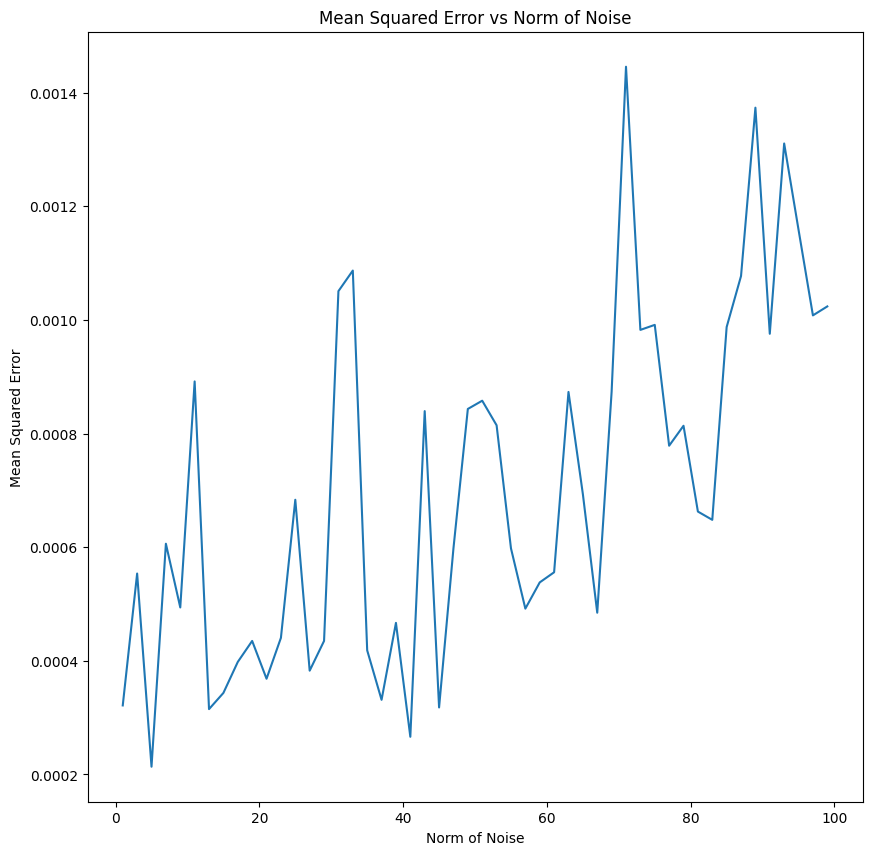

In [23]:
fig, arr = plt.subplots(1,1)
fig.set_size_inches(10, 10)

arr.plot(norms, avg_errs)
arr.set_title("Mean Squared Error vs Norm of Noise")
arr.set_xlabel('Norm of Noise')
arr.set_ylabel('Mean Squared Error')

## Varied Initialization Testing on Model Trained on Noise

In [72]:
all_losses = []
all_iters = []
all_errs = []
all_vals = [0.1] + [0.5*i for i in range(1,11)]
norms = [1, 5, 10, 20, 50]
for norm in norms:
    print(norm)
    nloss = []
    niters = []
    nerror = []
    for i in all_vals:
        total_loss = []
        total_iters = []
        total_errs = []
        for k in range(10):
            errs, steps, weights = find_weights(data, expected+n*norm, lamb=0.00001, stop=25, max_iter=50, variation=j)
            total_loss.append(errs[-1])
            total_iters.append(len(errs))
            total_errs.append(np.sum((f_vector(data, weights) - expected)**2))
        nloss.append(sum(total_loss)/500/len(total_loss))
        niters.append(sum(total_iters)/len(total_iters))
        nerror.append(sum(total_errs)/500/len(total_errs))
    all_losses.append(nloss)
    all_iters.append(niters)
    all_errs.append(nerror)

1
5
10
20
50


In [83]:
len(all_vals)

11

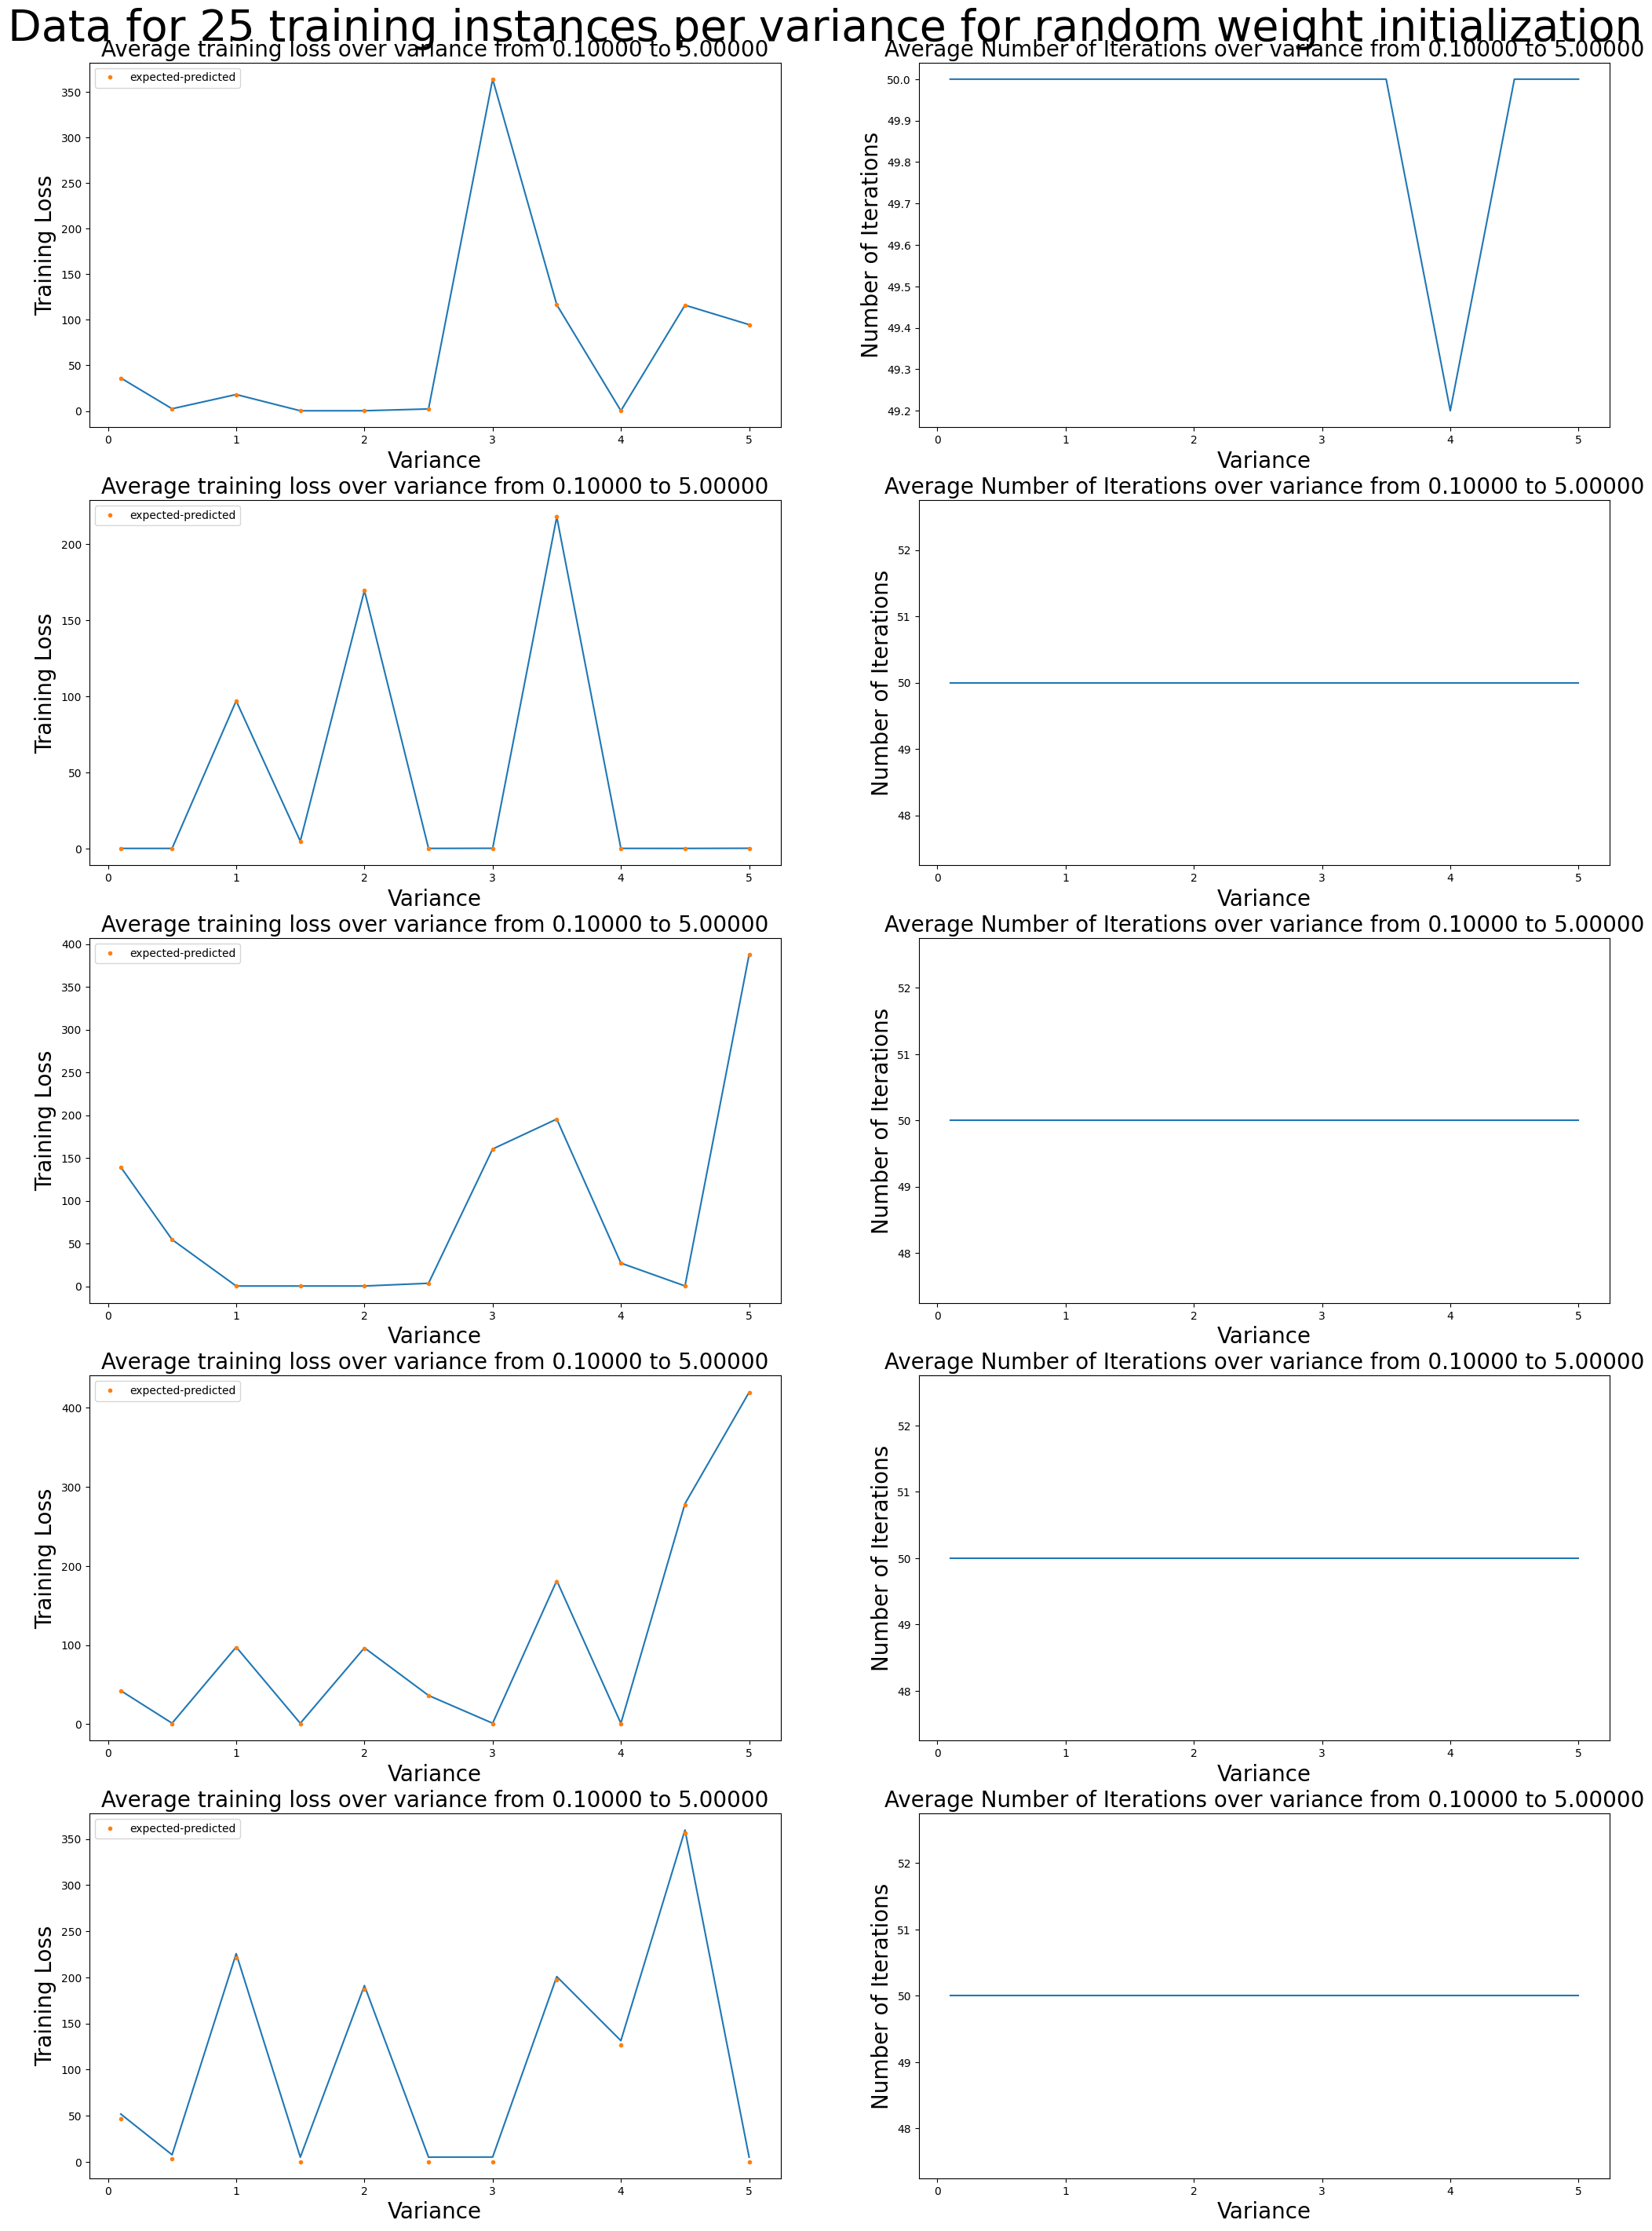

In [85]:
fig, arr = plt.subplots(len(norms),2)
fig.set_size_inches(25, 35)
fig.suptitle('Data for 25 training instances per variance for random weight initialization', fontsize=40, y=0.9)
for i in range(len(norms)):
    p = arr[i]
    p[0].plot(all_vals, all_losses[i])
    p[0].plot(all_vals, all_errs[i], '.', label='expected-predicted')
    p[1].plot(all_vals, all_iters[i])
    p[0].set_title(r'Average training loss over variance from {:.5f} to {:.5f}'.format(all_vals[0], all_vals[-1]), fontsize=20)
    p[0].set_xlabel(r'Variance', fontsize=20)
    p[0].set_ylabel('Training Loss', fontsize=20)
    p[0].legend(loc="upper left")
    p[1].set_title(r'Average Number of Iterations over variance from {:.5f} to {:.5f}'.format(all_vals[0], all_vals[-1]), fontsize=20)
    p[1].set_xlabel(r'Variance', fontsize=20)
    p[1].set_ylabel('Number of Iterations', fontsize=20)

In [87]:
lambs = [0.1] + [0.5*i for i in range(1,11)]
all_losses = []
all_iters = []
all_errs = []
norms = [1, 5, 10, 20, 50]
for norm in norms:
    print(norm)
    nloss = []
    niters = []
    nerror = []
    for l in lambs:
        total_loss = []
        total_iters = []
        total_errs = []
        for k in range(10):
            errs, steps, weights = find_weights(data, expected+n*norm, lamb=0, stop=25, max_iter=50)
            total_loss.append(errs[-1])
            total_iters.append(len(errs))
            total_errs.append(np.sum((f_vector(data, weights) - expected)**2))
        nloss.append(sum(total_loss)/500/len(total_loss))
        niters.append(sum(total_iters)/len(total_iters))
        nerror.append(sum(total_errs)/500/len(total_errs))
    all_losses.append(nloss)
    all_iters.append(niters)
    all_errs.append(nerror)

1
5
10
20
50


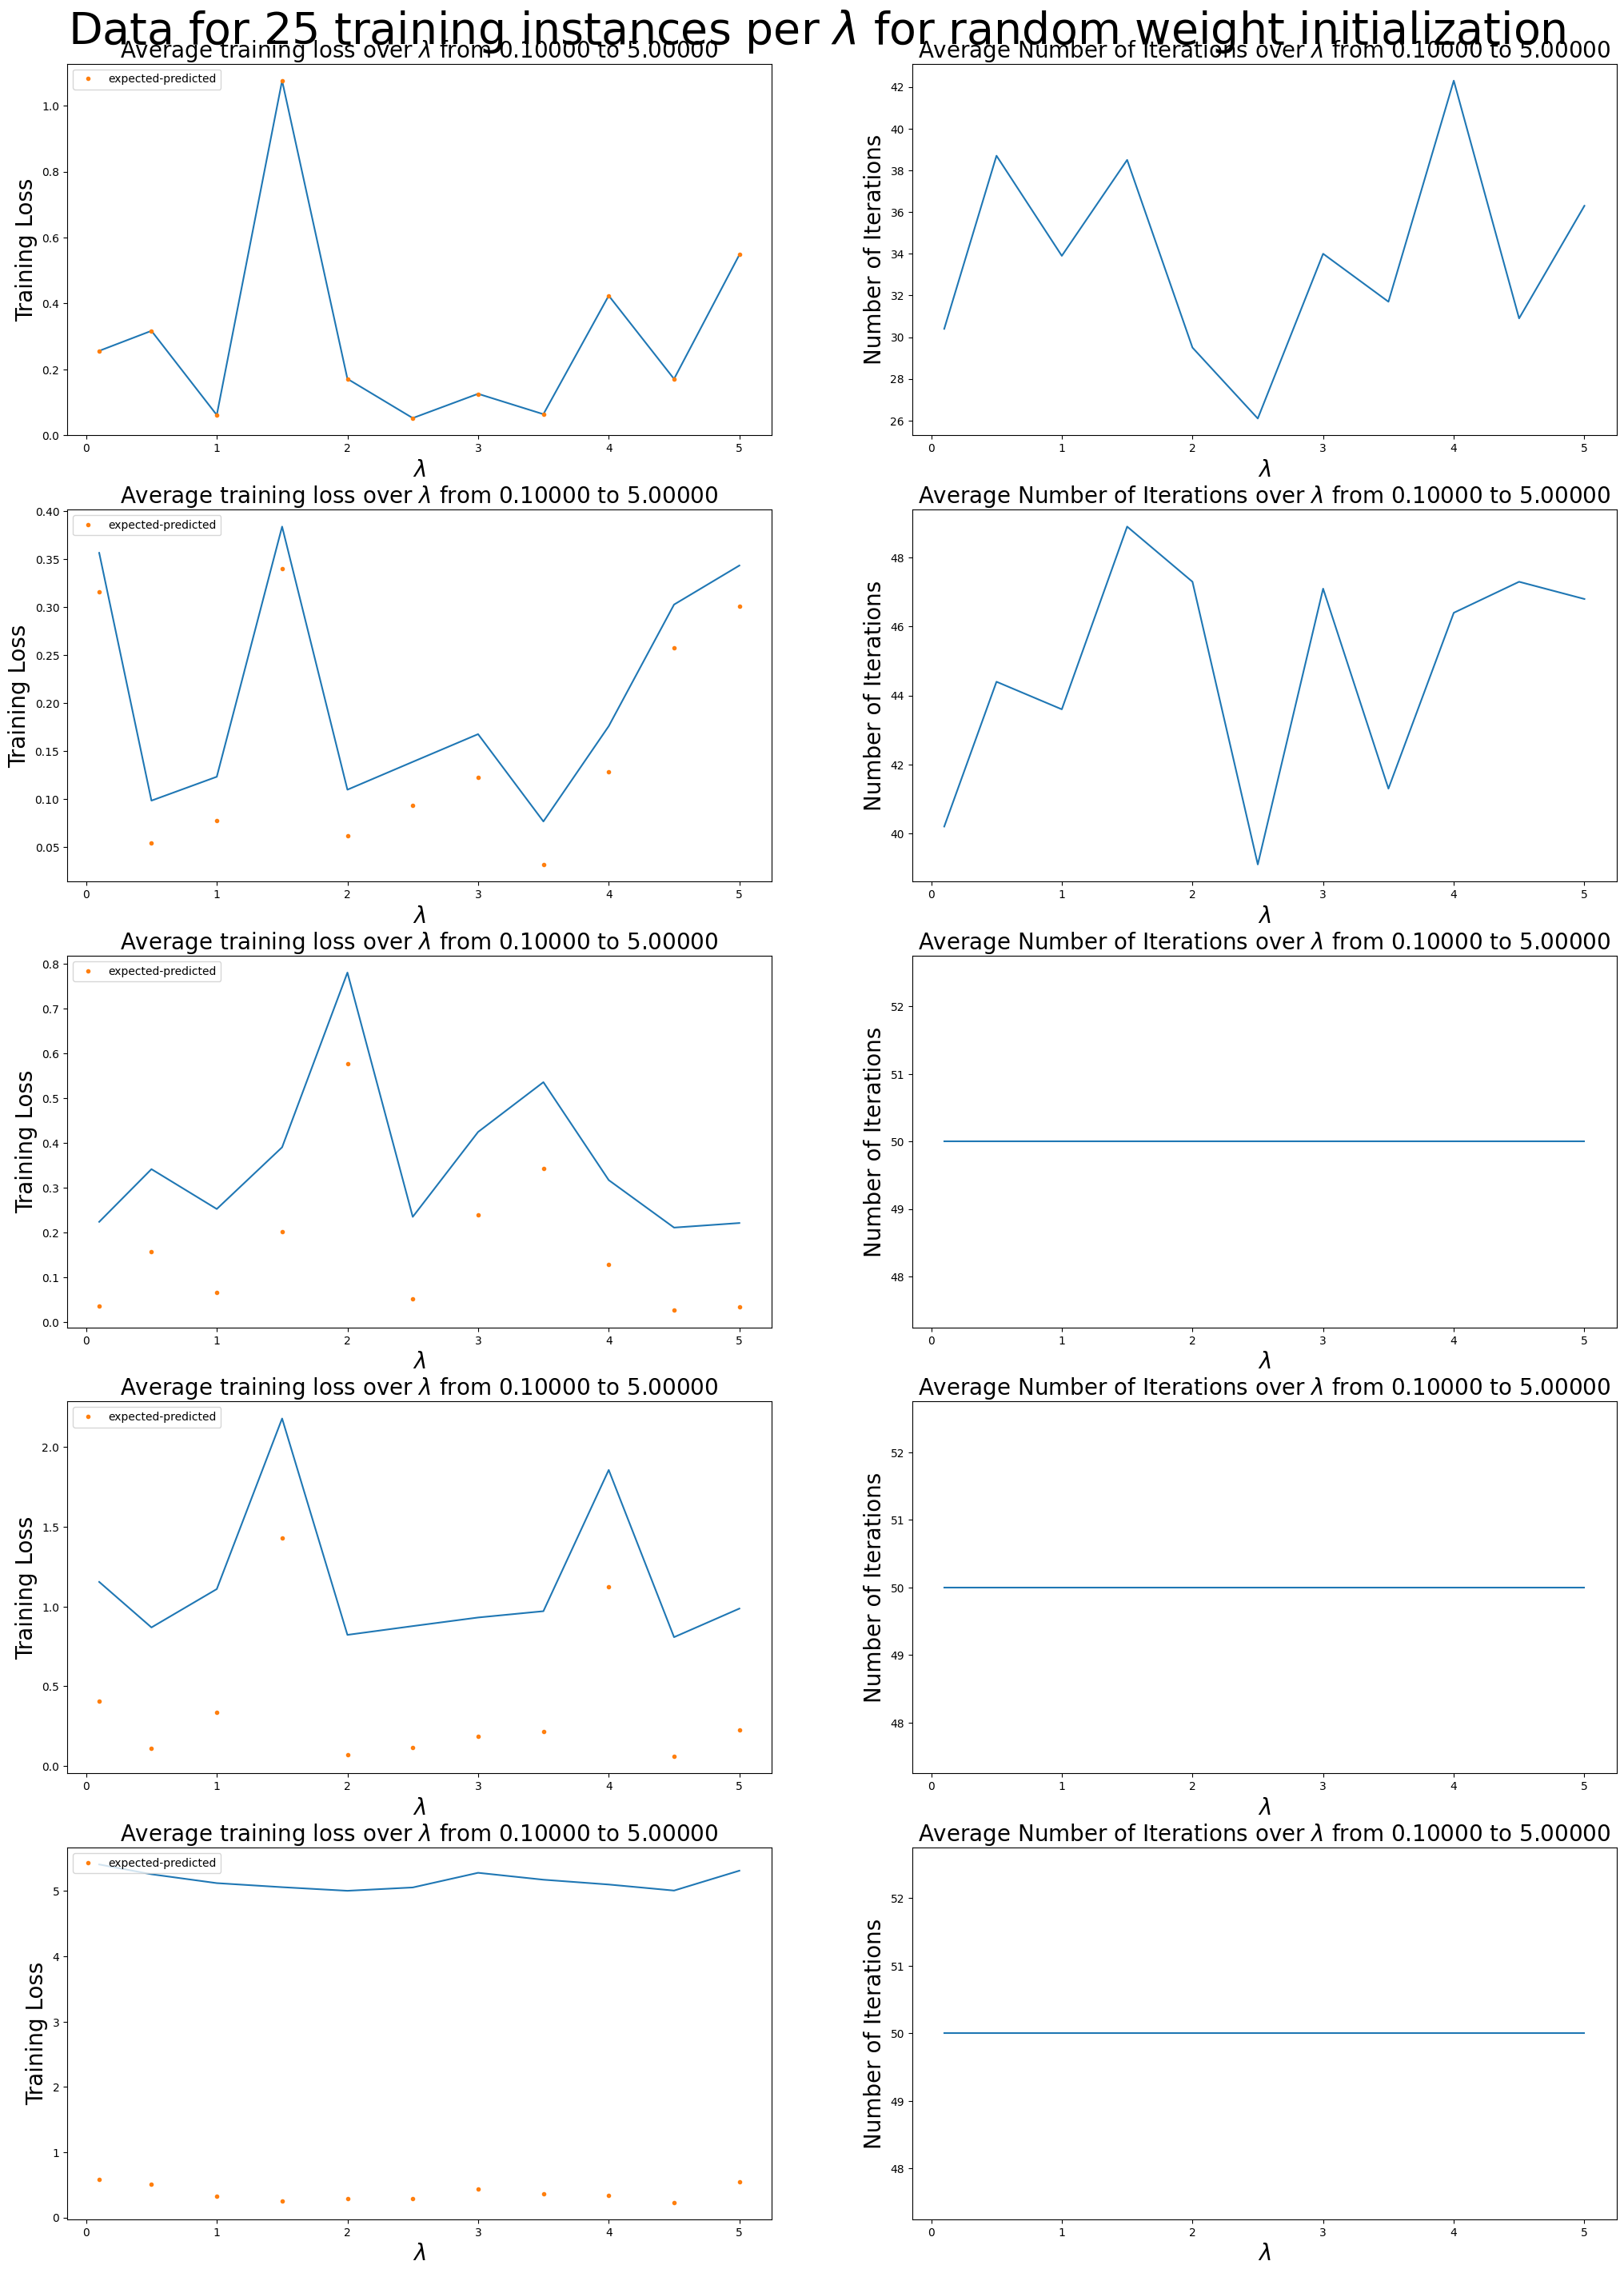

In [88]:
fig, arr = plt.subplots(len(norms),2)
fig.set_size_inches(25, 35)
fig.suptitle(r'Data for 25 training instances per $\lambda$ for random weight initialization', fontsize=40, y=0.9)
for i in range(len(norms)):
    p = arr[i]
    p[0].plot(all_vals, all_losses[i])
    p[0].plot(all_vals, all_errs[i], '.', label='expected-predicted')
    p[1].plot(all_vals, all_iters[i])
    p[0].set_title(r'Average training loss over $\lambda$ from {:.5f} to {:.5f}'.format(all_vals[0], all_vals[-1]), fontsize=20)
    p[0].set_xlabel(r'$\lambda$', fontsize=20)
    p[0].set_ylabel('Training Loss', fontsize=20)
    p[0].legend(loc="upper left")
    p[1].set_title(r'Average Number of Iterations over $\lambda$ from {:.5f} to {:.5f}'.format(all_vals[0], all_vals[-1]), fontsize=20)
    p[1].set_xlabel(r'$\lambda$', fontsize=20)
    p[1].set_ylabel('Number of Iterations', fontsize=20)

## Testing varied $\lambda$ and $\Gamma$  on new non-linear function

In [106]:
gammas = [1] + [i*(10**-2) for i in range(1, 1000)]
vals = [0.001, 0.01, 0.1, 1, 10, 100]
all_errs = []
data, expected = generate_data_1(500, 1)
w = np.random.normal(0,1,(16,))
for h in vals:
    print(h)
    errors = []
    for g in vals:
        _, _, weights = find_weights(data, expected+n*g, lamb=h, stop=25, max_iter=25, weights=w )
        avg_errs = []
        for i in range(len(gammas)):
            errs = []
            for j in range(25):
                data_new, data_expected = generate_data_1(100, gammas[i])
                err = np.sum((f_vector(data_new, weights) - data_expected)**2)
                errs.append(err)
            avg_errs.append(sum(errs)/len(errs)/len(vals))
        errors.append(avg_errs)
    all_errs.append(errors)

0.001
0.01
0.1
1
10
100


6


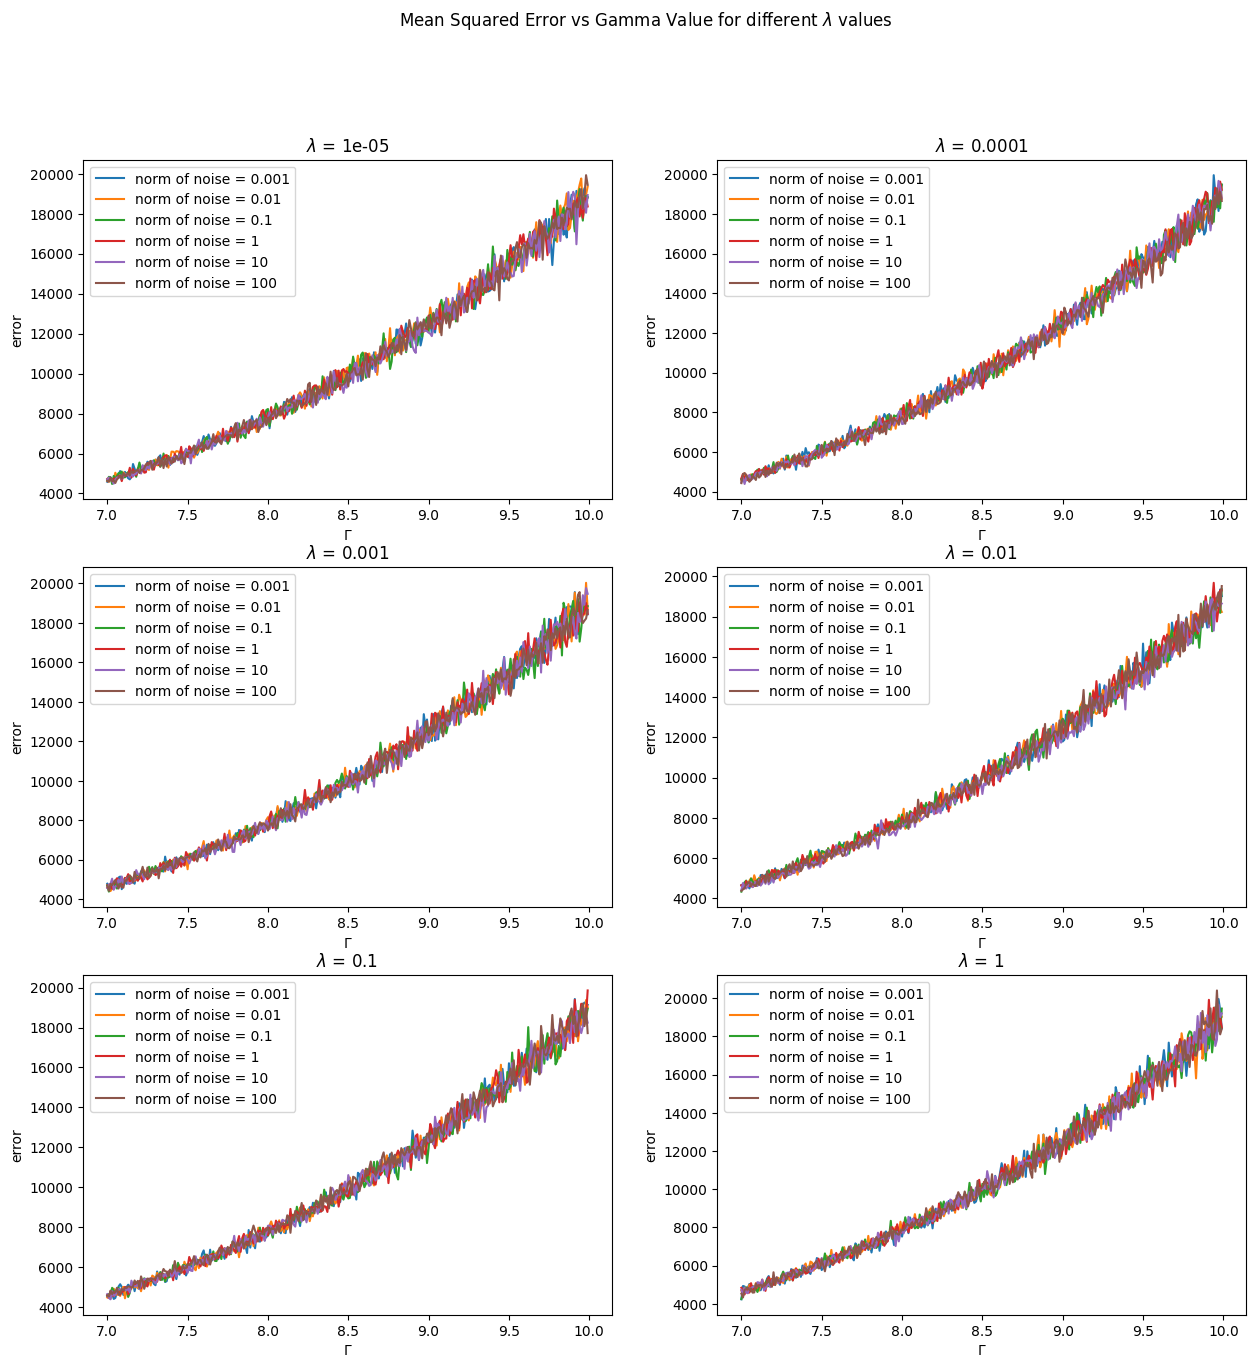

In [124]:
fig, arr = plt.subplots(int(len(all_errs)/2),2)
fig.set_size_inches(15, 15)
print(len(all_errs[0]))
for i in range(len(all_errs)):
    for j in range(len(all_errs[i])):
        p = arr[int(i/2)][int(i%2)]
        p.plot(gammas[700:1000], all_errs[i][j][700:1000], label=r'norm of noise = {}'.format(vals[j]))       
        p.set_xlabel(r'$\Gamma$')
        p.set_ylabel('error')
        p.legend(loc="upper left")
        p.set_title(r'$\lambda$ = {}'.format(str(lambs[i])))
fig.suptitle(r'Mean Squared Error vs Gamma Value for different $\lambda$ values')

plt.show()


# Visualization 

Create a set of $\textbf{x}$ such that $[x]_1[x]_2+[x]_3=\rho$

The model will provide the following about $\textbf{x}$
$$ [x]_1[x]_2+[x]_3 = f_{\textbf{w}}(\textbf{x})$$
Since in most cases $f_{\textbf{w}}(\textbf{x}) \neq 0$, we can calculate how much residuals exist bectween $f_{\textbf{w}}(\textbf{x})$ and $\rho$ by solving for $[x]_3$ in the equation above. Initially, we know that $[x]_!$ and $[x]_2$ are consistently throughout every single equation.
Redefine the equation from provided by the model and solve for $[x]_3'$ and subtract the two equations.
$$ [x]_1[x]_2+[x]_3' = f_{\textbf{w}}(\textbf{x})$$
$$\underline{-\quad[x]_1[x]_2+[x]_3=\rho\qquad\quad\;}$$
$$ [x]_3' - [x]_3 = f_{\textbf{w}}(\textbf{x}) - \rho$$
$$ [x]_3' = [x]_3 + f_{\textbf{w}}(\textbf{x}) - \rho$$

In [342]:
def contour_plot(weights, rho, alpha, N=100):
    data = np.random.uniform(-alpha, alpha, (N,2))
    data_expected = np.concatenate((data, np.reshape(rho-np.multiply(data[:,0],data[:,1]), (N,1))), axis=1)

    x1 = data_expected[:,0]
    y1 = data_expected[:,1]
    z1 = data_expected[:,2]
    # compute fw
    data_predicted = np.empty((0,1))
    for row in data_expected:
        data_predicted = np.vstack((data_predicted, f(row, min_weights)))
    x2 = data_expected[:,0]
    y2 = data_expected[:,1]
    z2 = data_expected[:,2] + data_predicted[:,0] - rho
    
    avg_err = np.sum(np.square(z2 - z1))/N
    
    return x1, y1, z1, x2, y2, z2, avg_err

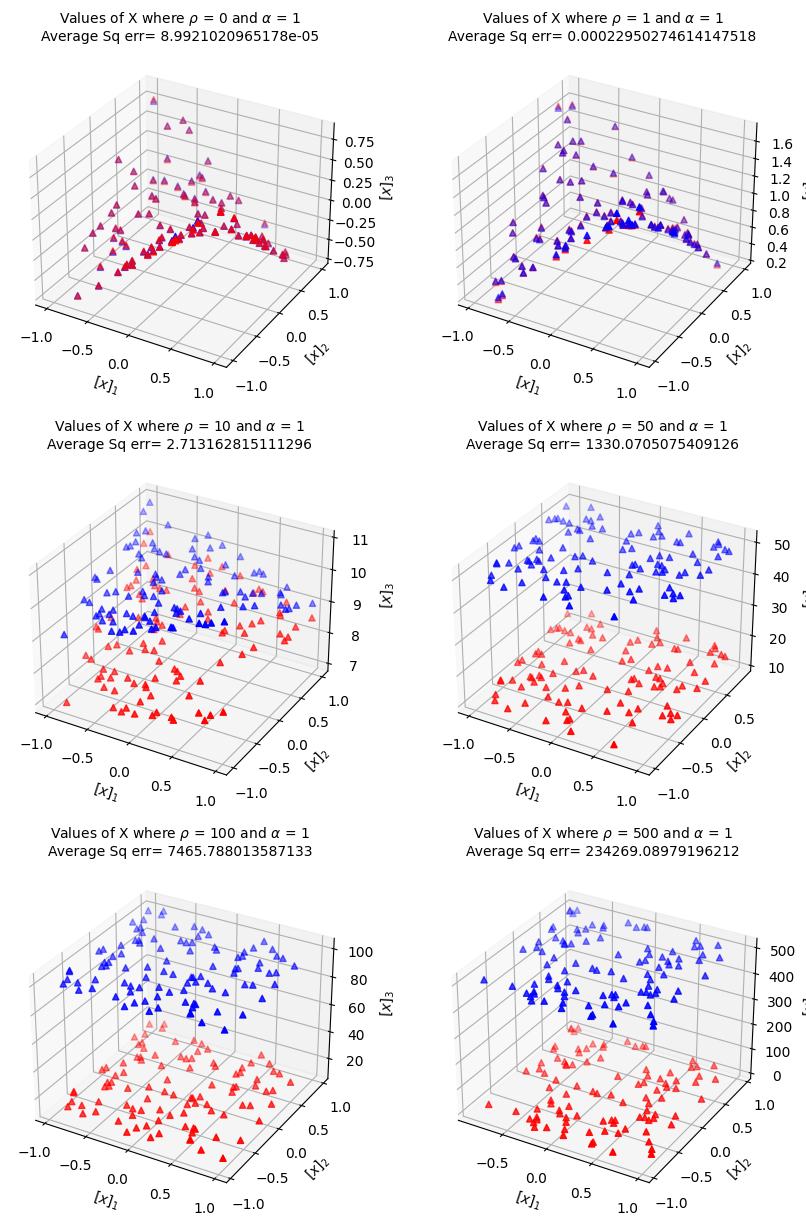

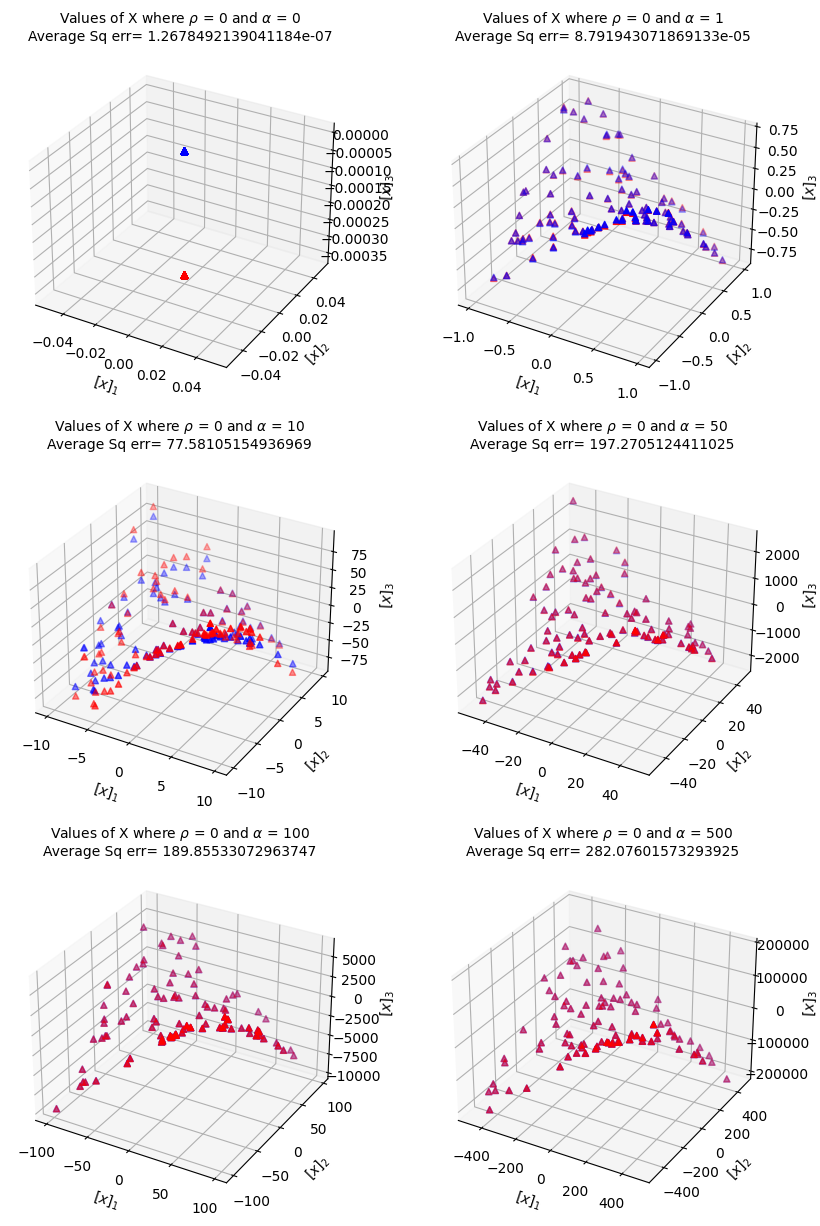

In [404]:
fig = plt.figure()
fig.set_size_inches(10, 15)
all_vals = [val for val in range(1001)]
vals = [0,1,10,50, 100, 500]
errs_rho = []
for i in range(len(all_vals)):
    x1, y1, z1, x2, y2, z2, avg = contour_plot(min_weights, all_vals[i], 1)
    errs_rho.append(avg)
    if i in vals:
        index = vals.index(i)
        ax = fig.add_subplot(int(len(vals)/2),2,index+1, projection='3d')
        ax.scatter(x1, y1, z1, marker="^", c='blue')
        ax.scatter(x2, y2, z2, marker="^", c='red')
        ax.set_xlabel(r'$[x]_1$')
        ax.set_ylabel(r'$[x]_2$')
        ax.set_zlabel(r'$[x]_3$')
        ax.set_title(r'Values of X where $\rho$ = {} and $\alpha$ = 1' '\n' 'Average Sq err= {}'.format(i, str(avg)), fontsize=10)
plt.show()

fig = plt.figure()
fig.set_size_inches(10, 15)
errs_alpha = []
for i in range(len(all_vals)):
    x1, y1, z1, x2, y2, z2, avg = contour_plot(min_weights, 0, all_vals[i])
    errs_alpha.append(avg)
    if i in vals:
        index = vals.index(i)
        ax = fig.add_subplot(int(len(vals)/2),2,index+1, projection='3d')
        ax.scatter(x1, y1, z1, marker="^", c='blue')
        ax.scatter(x2, y2, z2, marker="^", c='red')
        ax.set_xlabel(r'$[x]_1$')
        ax.set_ylabel(r'$[x]_2$')
        ax.set_zlabel(r'$[x]_3$')
        ax.set_title(r'Values of X where $\rho$ = 0 and $\alpha$ = {}' '\n' 'Average Sq err= {}'.format(i, str(avg)), fontsize=10)
plt.show()

Text(0, 0.5, 'Average Squared Error')

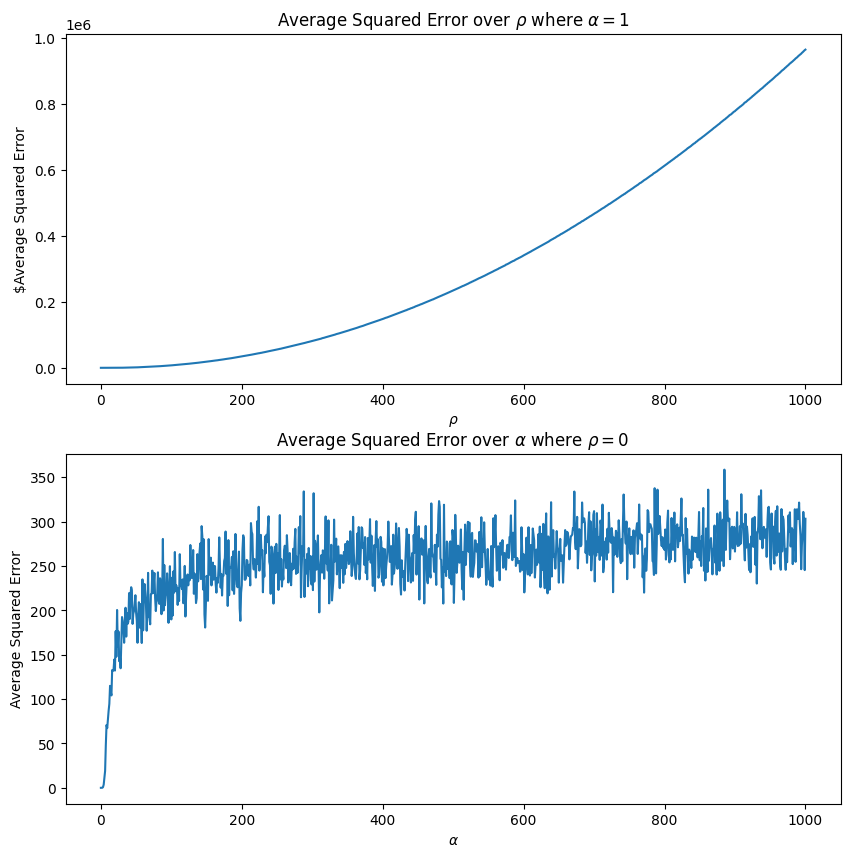

In [407]:
fig, arr = plt.subplots(2,1)
fig.set_size_inches(10,10)
arr[0].plot(all_vals, errs_rho)
arr[0].set_title(r'Average Squared Error over $\rho$ where $\alpha=1$')
arr[0].set_xlabel(r'$\rho$')
arr[0].set_ylabel(r'$Average Squared Error')
arr[1].plot(all_vals, errs_alpha)
arr[1].set_title(r'Average Squared Error over $\alpha$ where $\rho=0$')
arr[1].set_xlabel(r'$\alpha$')
arr[1].set_ylabel(r'Average Squared Error')